# Example pipeline for ActFlowCategories GitHub repository [see here]

[see here]: https://github.com/ColeLab/ActFlowCategories

In [1]:
# This notebook demonstrates core analyses from: 

# Distributed network processes account for the majority of variance in localized visual category selectivity.
# Carrisa V. Cocuzza, Ruben Sanchez-Romero, Takuya Ito, Ravi D. Mill, Brian P. Keane, Michael W. Cole.
# bioRxiv 2022.02.19.481103; doi: https://doi.org/10.1101/2022.02.19.481103

In [2]:
# Notes:

# This uses example data from the HCP S1200 young adult release; see here: 
# https://www.humanconnectome.org/study/hcp-young-adult/document/1200-subjects-data-release

# In the manuscript, we assessed N=352 (with split-half validation: n=176/discovery and replication sets).
# In this notebook (supported by corresponding GitHub files), we demonstrate analyses for a subset of n=20.
# Thus, results (statistics, figures, etc.) may not match manusript exactly because full sample not used.
# This is due to GitHub memory limits; please contact Carrisa Cocuzza (carrisacocuzza@gmail.com) or 
# see the HCP release listed above for more data. 
# The main goal of this notebook is to demonstrate how to use the core analysis scripts (python 3+)
# in future work wishing to apply these methods.

# Import packages and set paths

In [73]:
# PACKAGES/MODULES/LIBRARIES: install these as needed, see:
# https://packaging.python.org/en/latest/tutorials/installing-packages/

# Relatively standard packages:
import numpy as np
import pandas as pd
import pickle
import math as math
import importlib
import scipy.io as spio 
import scipy.io as spio 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import matplotlib.colors as clrs
from matplotlib import colorbar
from matplotlib.font_manager import FontProperties
import h5py
import statsmodels
import statsmodels.api as sm
import sklearn as sklearn 
import time
import pytest
from scipy import stats
from numpy import save
from numpy import load
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.stats.weightstats as sms

# Somewhat non-standard/may need to be installed/configuration checked for your OS.
import sys
import os
import os.path
import importlib
import pkg_resources
import nibabel as nb
from wbplot import pscalar
from wbplot import constants


In [93]:
# PACKAGES/MODULES/LIBRARIES continued...
# Non-standard / GitHub based packages. Install these as needed, following: 
# https://docs.github.com/en/repositories/creating-and-managing-repositories/cloning-a-repository

# Activity Flow Mapping (Cole et al., 2016). 
# See https://github.com/ColeLab/ActflowToolbox
# Recommended: clone this into scripts_dir (see cell below).
# See here for protocol: 
# Cocuzza et al. (2022). Protocol for activity flow mapping of neurocognitive 
# computations using the Brain Activity Flow Toolbox. STAR Protocols, 3(1), 101094.
af_dir = '/Users/carrisacocuzza/Google Drive/LabMacBookDrive/RUTGERS/lab/Projects/movieActFlow/maf_local_git_testing/'
sys.path.insert(0, af_dir)
import ActflowToolbox as actflow

# Import scripts/function from this repo:
import category_selectivity as cs 
import dominance_analysis_V2 as da
import glasser_ordering as glo
import maxT_pyVer as nppt
import selectivity_outlier_handling as soh

In [37]:
# PATHS: change these as needed for your local machine.

# Parent directory: change this to match your local machine / desired parent path 
parent_dir = '/Users/carrisacocuzza/Google Drive/LabMacBookDrive/RUTGERS/lab/Projects/movieActFlow/'
    
# Data, scripts, and figures directories. Change these as needed 
scripts_dir = parent_dir + 'maf_local_git_testing/'
data_dir = parent_dir + 'maf_local_git_testing/example_data/'
figures_dir = parent_dir + 'maf_local_git_testing/demo_figures/'

# Check that paths exist
if not os.path.exists(parent_dir):
    print(f"{parent_dir} does not exist, please check or make the directory (mkdir).")
if not os.path.exists(data_dir):
    print(f"{data_dir} does not exist, please check or make the directory (mkdir).")
if not os.path.exists(scripts_dir):
    print(f"{scripts_dir} does not exist, please check or make the directory (mkdir).")
if not os.path.exists(figures_dir):
    print(f"{figures_dir} does not exist, please check or make the directory (mkdir).")
    
if os.path.exists(parent_dir) and os.path.exists(data_dir):
    if os.path.exists(scripts_dir) and os.path.exists(figures_dir):
        print(f"All paths exist.")
    

All paths exist.


In [22]:
# HELPER FUNCTIONS 

####################################################################################
def coloredText(r, g, b, text):
    return "\033[38;2;{};{};{}m{} \033[38;2;255;255;255m".format(r, g, b, text)

# Data

## Atlases

In [19]:
# Data and specs related to cortical atlas and network partition

# Cortical atlas: multimodal parcellation (MMP), reference:
# Glasser et al. (2016). A multi-modal parcellation of human cerebral cortex. Nature, 536(7615), 171-178.

# Network partition: Cole-Anticevic brain-wide network partition (CAB-NP), reference:
# Ji et al. (2019). Mapping the human brain's cortical-subcortical functional network organization. 
# Neuroimage, 185, 35-57.
# GitHub: https://github.com/ColeLab/ColeAnticevicNetPartition

# Fixed variables 
num_nets = 12 # number of functional networks in CAB-NP
num_parcels = 360 # number of cortical regions in MMP (each hemisphere = 180)

# Helper files: order of MMP regions into CAB-NP network organization
# Note: node_indices[node_order] should show an ordered community assignment vector
# Note: node_order can be used to sort MMP-region-based-connectivity-graphs, ex: fc_mat[node_order,:][:,node_order]
node_order = spio.loadmat(data_dir + 'nodeOrder.mat')['nodeOrder'][:,0] - 1
node_indices = np.float64(spio.loadmat(data_dir + 'nodeIndices.mat')['nodeIndices'][:,0]) -1
node_order = node_order.astype(int)
node_indices = node_indices.astype(int)

# Helper files: also assists in ordering MMP regions into CAB-NP
# Note: cortex_comm_order and cortex_parcel_net_assign in original numbering (starting at 1; non-pythonic)
cortex_comm_order_file = data_dir + 'cortex_community_order.txt'
cortex_parcel_net_assign_file = data_dir + 'cortex_parcel_network_assignments.txt'
cortex_comm_order = np.loadtxt(cortex_comm_order_file)
cortex_parcel_net_assign = np.loadtxt(cortex_parcel_net_assign_file)

# Helper variable boundaries_CA: when a region-wise vector is sorted by CAB-NP networks (ex: my_vec[node_order]).
# Note: boundaries_CA should only be used after vectors are sorted with node_order.
# column 0 = start index; column 1 = end index (make sure to use +1 for python end-indexing); column 2 = net size 
boundaries_CA = np.zeros((num_nets,3))
for net_num in range(num_nets): 
    this_net_start = np.asarray(np.where(np.sort(cortex_parcel_net_assign)==net_num+1))[:,0]
    this_net_size = np.asarray(np.where(np.sort(cortex_parcel_net_assign)==net_num+1)).shape[1]
    this_net_end = np.asarray(np.where(np.sort(cortex_parcel_net_assign)==net_num+1))[:,this_net_size-1]
    boundaries_CA[net_num,0] = this_net_start
    boundaries_CA[net_num,1] = this_net_end
    boundaries_CA[net_num,2] = this_net_size
    

In [28]:
# Continued from above...

# CAB-NP standardized network colors; RGB triplets from network_labelfile.txt
# see also https://greenteapress.com/thinkpython/code/color_list.py 
# for possibly more accurate mappings to above strings 
network_palette_nums = [[0,0,255],[200,0,255],[0,255,255],[153,0,153],
                        [0,255,0],[0,154,154],[255,255,0],[249,61,251],
                        [255,0,0],[177,89,40],[255,156,0],[65,124,0]]
ordered_networks_long = ['Primary Visual Network','Secondary Visual Network','Somatomotor Network',
                         'Cingulo-Opercular Network','Dorsal Attention Network','Language Network',
                         'Frontoparietal Network','Auditory Network','Default Mode Network',
                         'Posterior Multimodal Network','Ventral Mulitmodal Network','Orbito-affective Network']
color_list = [(0, 0, 1),(0.3922, 0, 1),(0, 1, 1),(0.6, 0, 0.6),
              (0, 1, 0),(0, 0.6, 0.6),(1, 1, 0),(0.98, 0.24, 0.98),
              (1, 0, 0),(0.7, 0.35, 0.16),(1, 0.6, 0),(0.25, 0.5, 0)]

# Standard network numberings
network_mappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 
                    'aud':8, 'lan':6, 'dan':5, 'con':4, 
                    'dmn':9, 'pmulti':10, 'vmm':11, 'ora':12}

# Other CAB-NP helper files and variables 
networks = network_mappings.keys()
network_def = np.loadtxt(data_dir + '/cortex_parcel_network_assignments.txt')
network_order = np.asarray(sorted(range(len(network_def)), key=lambda k: network_def[k]))
network_order.shape = (len(network_order),1)
net_order = network_order[:,0]

# Can be used on connectivity graphs for x and y tick locations 
xticks = {}
reordered_network_affil = network_def[network_order]
for net in networks:
    net_num = network_mappings[net]
    net_ind = np.where(reordered_network_affil==net_num)[0]
    tick = np.max(net_ind)
    xticks[tick] = net

# Ordered list of strings for network acronyms
sorted_nets = np.sort(list(xticks.keys()))
ordered_networks = []
for net in sorted_nets: 
    ordered_networks.append(xticks[net])
    
# When region-wise vectors are not sorted, this can be used to index parcels of a given network (in python style): 
parcel_net_ixs = {}
for net_num in range(num_nets): 
    parcel_net_ixs[net_num] = np.asarray(np.where(cortex_parcel_net_assign==net_num+1))

# More recent acronyms for CAB-NP & print out colorings for sanity check / reference
ordered_nets_caps = ['VIS1','VIS2','SMN','CON','DAN','LAN',
                     'FPN','AUD','DMN','PMM','VMM','OAN']
print('\nCAB-NP network names and colors (in standard order): ')
for net_num in range(num_nets):
    print(coloredText(0,0,0,ordered_networks_long[net_num] + 
                      ' (' + ordered_nets_caps[net_num] + ')') +  
          coloredText(network_palette_nums[net_num][0],
                      network_palette_nums[net_num][1],
                      network_palette_nums[net_num][2],
                      network_palette_nums[net_num]))


CAB-NP network names and colors (in standard order): 
Primary Visual Network (VIS1) [0, 0, 255] 
Secondary Visual Network (VIS2) [200, 0, 255] 
Somatomotor Network (SMN) [0, 255, 255] 
Cingulo-Opercular Network (CON) [153, 0, 153] 
Dorsal Attention Network (DAN) [0, 255, 0] 
Language Network (LAN) [0, 154, 154] 
Frontoparietal Network (FPN) [255, 255, 0] 
Auditory Network (AUD) [249, 61, 251] 
Default Mode Network (DMN) [255, 0, 0] 
Posterior Multimodal Network (PMM) [177, 89, 40] 
Ventral Mulitmodal Network (VMM) [255, 156, 0] 
Orbito-affective Network (OAN) [65, 124, 0] 


In [29]:
# Helper files for HCP workbench visualizations; see here for more on nifti files: 
# https://wiki.humanconnectome.org/display/WBPublic/Workbench+Glossary

# Left nodes: 32492 vector, left hemisphere cortical vertex labels (label = Glasser parcel, or NaN)
file_name_L = 'Q1-Q6_RelatedValidation210.L.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii'
ciftiFileLeft = data_dir + file_name_L 
#leftNodes = nib.load(ciftiFileLeft).get_fdata(); leftNodes = np.squeeze(leftNodes);

# Right nodes: 32492 vector, right hemisphere cortical vertex labels (label = Glasser parcel, or NaN)
file_name_R = 'Q1-Q6_RelatedValidation210.R.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii'
ciftiFileRight = data_dir + file_name_R 
#rightNodes = nib.load(ciftiFileRight).get_fdata(); rightNodes = np.squeeze(rightNodes);

# Network references: 96854 vector, whole brain vertex labels (label = CABNP network 1-12, or NaN)
# 96854 x 1, whole brain vertex labels (label = CABNP network 1-12, or NaN); NOTE: hand fixed 
net_ref = spio.loadmat(data_dir + 'netRefNew.mat')['netRefNew']


## Sample

In [30]:
# HCP n=20 sample-related data specs and files 

subj_nums = ['100206','108020','117930','126325',
             '133928','143224','153934','164636',
             '174437','183034','194443','204521',
             '212823','268749','322224','385450',
             '463040','529953','587664','656253']
num_subjs = len(subj_nums)

print(f"Number of participants: {num_subjs}")


Number of participants: 20


## Task information

In [42]:
# HCP S1200 7-task (totaling 24 conditions) specs
task_conditions = ['Emotion: fear','Emotion: neutral','Gambling: win',
                   'Gambling: loss','Language: story','Language: math',
                   'Motor: cue','Motor: left foot','Motor: right foot',
                   'Motor: left hand','Motor: right hand','Motor: tongue',
                   'Relational: relation','Relational: match',
                   'Social: mental','Social: random',
                   '0-back: bodies','2-back: bodies','0-back: faces',
                   '2-back: faces','0-back: places','2-back: places',
                   '0-back: tools','2-back: tools']
num_conditions = len(task_conditions)

# Task activations 

In [43]:
# Load task activations 
# Note: pre-processed outside this example notebook;
# see manuscript for details or contact carrisacocuzza@gmail.com

startTime = time.time()

dataSuffix = '_taskbetas24cond_noncirc_data'
outname1 = 'taskbeta'

################################################################################
# LOAD
activations_bycond = np.zeros((num_parcels,num_parcels,num_conditions,num_subjs)) 
for subjIx in list(range(num_subjs)):
    subj = subj_nums[subjIx]
    file_path = data_dir + subj + dataSuffix + '.h5'
    h5f = h5py.File(file_path,'r')
    activations_bycond[:,:,:,subjIx] = h5f[outname1][:]
    h5f.close() 

################################################################################
# Given the preprocessing step of 10 mm dilated masking (of source vertices; see manuscript Methods details) 
# using tools from https://github.com/ColeLab/ActflowToolbox/, the diagonal needs to be extracted 
activations_vertexavg_bycond = np.zeros((num_parcels,num_conditions,num_subjs))
for nodeNum in range(num_parcels):
    for condNum in range(num_conditions):
        for subjNum in range(num_subjs):
            activations_vertexavg_bycond[nodeNum,condNum,subjNum] = activations_bycond[nodeNum,
                                                                                       nodeNum,
                                                                                       condNum,
                                                                                       subjNum]
            
endTime = time.time()
timeDiff = np.round(((endTime-startTime)/60),2)
print(f"Cell run time: {timeDiff} minutes.")

Cell run time: 0.13 minutes.


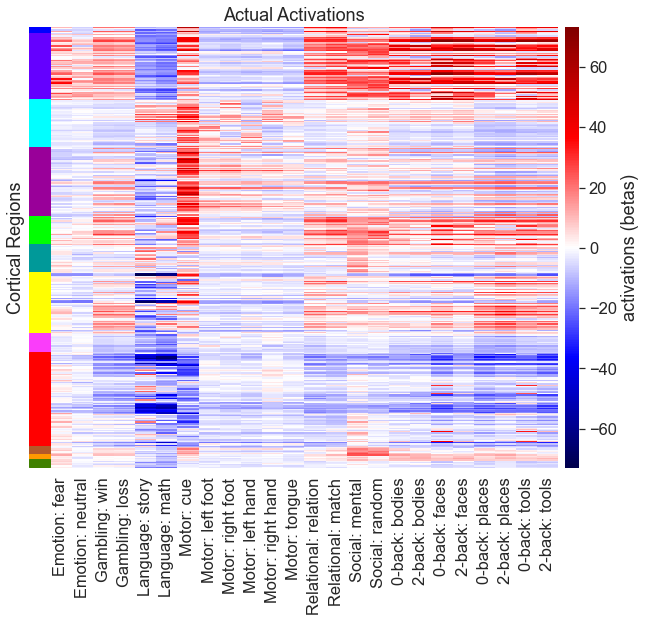

In [61]:
# Visualize actual activations: MMP regions sorted on y-axis by CAB-NP network
# Mean across subjects 

################################################################################
# Initialize some variables 
buffSize = 1
matrixHere = np.nanmean(activations_vertexavg_bycond,axis=2)[node_order,:]
xTicks = np.arange(num_conditions) + buffSize + 0.5
xTickLabels = task_conditions
yTickLabels = []

################################################################################
# Make room in matrix for network axis labels, which will be filled in with color 'patches'
topSize = (num_parcels,buffSize)
topBuff = np.zeros((topSize))
topBuff = (topBuff + 1) * 0.31
matWithBuffer = np.hstack((topBuff,matrixHere))

################################################################################
# Draw figure 
sns.set(font_scale=1.5)
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10,7))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
pH = sns.heatmap(matWithBuffer,center=0,cmap='seismic',
                 cbar_kws={'label':'activations (betas)','pad':0.01,'aspect':30},
                 yticklabels=yTickLabels,xticklabels=xTickLabels)
plt.subplots_adjust(left=None,bottom=None,right=1,top=1,wspace=1,hspace=1)
ax.set_xticks(xTicks)
ax.set_xticklabels(task_conditions,rotation=90)

################################################################################
# Add network colors labels on y-axis as patches 
for net in range(num_nets):
    netSize = int(boundaries_CA[net,2])
    netStart = int(boundaries_CA[net,0])
    rectV = patches.Rectangle((0,netStart-1),buffSize,netSize,linewidth=1,
                              edgecolor=color_list[net],facecolor=color_list[net])
    ax.add_patch(rectV)
    
rectWhite = patches.Rectangle((num_parcels-1,num_conditions-1),buffSize,buffSize,
                              linewidth=1,edgecolor='white',facecolor='white')
ax.add_patch(rectWhite)

################################################################################
# Plot labels and show 
plt.title('Actual Activations')
plt.ylabel('Cortical Regions')
plt.show()

################################################################################
# Save 
figName = figures_dir + 'actual_activations_all_conditions_subject_means.png'
fig.savefig(figName,bbox_inches='tight',format='png',dpi=600)

# Functional connectivity

In [ ]:
# Functional connectivity estimation was performed on resting-state data (rsFC).

# See here for an analysis of different connectivity estimates for activity flow mapping: 
# Cole, M. W., Ito, T., Cocuzza, C., & Sanchez-Romero, R. (2021). 
# The functional relevance of task-state functional connectivity. Journal of Neuroscience, 41(12), 2684-2702.

# See here for an outlook on the current considerations/limits/prospects for FC in brain research:
# Reid, A. T., Headley, D. B., Mill, R. D., Sanchez-Romero, R., Uddin, L. Q., Marinazzo, D.,...& Cole, M. W. (2019). 
# Advancing functional connectivity research from association to causation. Nature neuroscience, 22(11), 1751-1760.

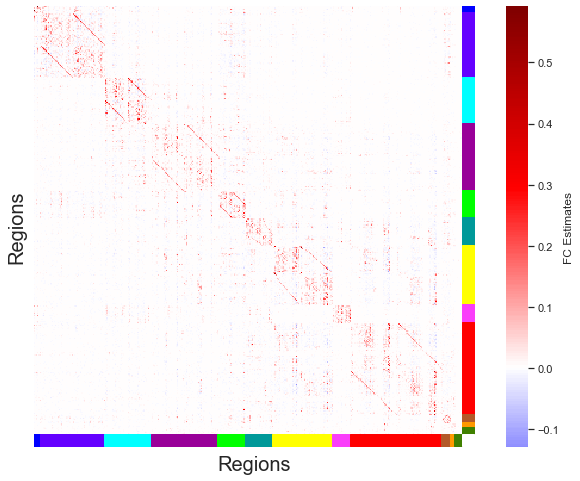

In [63]:
# Load a subset of n=20 participants rsFC data, computed with combined FC (Sanchez-Romero & Cole, 2021.)
# Note: pre-computed outside this example notebook; see manuscript for details or contact carrisacocuzza@gmail.com
# Also see Sanchez-Romero and Cole, 2021 for more details, or, https://github.com/ColeLab/CombinedFC.

#################################################################################
# LOAD 
restFC = load(data_dir + 'restFC.npy')

#################################################################################
# Visualize 
# NOTE: for some python versions, this built-in visualization (of the Activity Flow Toolbox) 
# may show the wrong colormap. If so (too many blues/wrong scaling), see silenced code at bottom. 
fcMat = np.nanmean(restFC[node_order,:,:][:,node_order,:],axis=2)
figH = actflow.tools.addNetColors_Seaborn(fcMat)

#################################################################################
# Code that can be used as an alternative to the above if colormap looks off:
#fcMat = np.nanmean(restFC[node_order,:,:][:,node_order,:],axis=2)
#numYticks = num_nets
#yTicks = boundaries_CA[:,1]
#yTickLabels = ['-'] * num_nets
#fH = 15/1.5
#fW = 12/1.5
#figH, ax = plt.subplots(1,figsize=(fH,fW))
#sns.heatmap(fcMat,center=0,cmap='seismic',cbar=True,ax=ax,cbar_kws={'pad':0.01,'aspect':30})
#ax.set_yticks(yTicks)
#ax.set_xticks(yTicks)
#ax.set_yticklabels(yTickLabels)
#ax.set_xticklabels(yTickLabels,rotation=90)
#plt.show()

#################################################################################
# SAVE 
figName = figures_dir + 'rest_FC_subject_means.png'
figH.savefig(figName,bbox_inches='tight',format='png',dpi=600)

# Functional complexes

In [ ]:
# A "functional complex" here is a set of MMP regions that 
# correspond to classically-studied local visual category fROIs.
# For example: fusiform face area (FFA) and posterior superior temporal sulcus (pSTS) for face images.

In [67]:
# Note: these were pre-determined by a series of meta-analyses that are outlined in the manuscript.
# TBA: a script or section of this notebook detailing these steps. 
# If this is not added by the time you are viewing this and you'd like more information,
# please contact Carrisa at carrisacocuzza@gmail.com

parcelOfInterest_All = [1,135,137,155,156,17,128,129,30,125,126,
                        152,153,154,159,5,6,19,20,21,157,181,315,
                        317,335,336,197,308,309,210,305,306,332,
                        333,334,339,185,186,199,200,201,337]

# BODIES #################################################################################
# Extrastriate body area (EBA) and fusiform body area (FBA)
taskOfInterest_body = 0
parcelOfInterestL_body = [1, 135, 137, 155, 156]
parcelOfInterestR_body = [181, 315, 317, 335, 336]
parcelStrComp_body = 'EBA_FBA'

# FACES #################################################################################
# Fusiform face area (FFA) and posterior superior temporal sulcus (pSTS)
taskOfInterest_face = 1
parcelOfInterestL_face = [17, 128, 129]
parcelOfInterestR_face = [197, 308, 309]
parcelStrComp_face = 'FFA_pSTS'

# PLACES #################################################################################
# Parahippocampal place area (PPA) and retrosplenial cortex/complex (RSC)
taskOfInterest_place = 2
parcelOfInterestL_place = [30, 125, 126, 152, 153, 154, 159]
parcelOfInterestR_place = [210, 305, 306, 332, 333, 334, 339]
parcelStrComp_place = 'PPA_RSC'

# TOOLS #################################################################################
# Lateral occipital complex/cortex (LOC)
taskOfInterest_tool = 3
parcelOfInterestL_tool = [5, 6, 19, 20, 21, 157]
parcelOfInterestR_tool = [185, 186, 199, 200, 201, 337]
parcelStrComp_tool = 'LOC'


# Activity flow mapping

In [ ]:
# Note that only n=20 demo'd here, see manuscript for results for full dataset.

In [64]:
# See here for original activity flow mapping work: 
# Cole, M. W., Ito, T., Bassett, D. S., & Schultz, D. H. (2016). Activity flow 
# over resting-state networks shapes cognitive task activations. Nature neuroscience, 19(12), 1718-1726.

# See here for protocol: 
# Cocuzza, C. V., Sanchez-Romero, R., & Cole, M. W. (2022). Protocol for activity flow 
# mapping of neurocognitive computations using the Brain Activity Flow Toolbox. STAR Protocols, 3(1), 101094.

startTime = time.time();

################################################################################
print('******** Activity flow mapping: combinedFC & multiple regression' + 
      ' rsFC; 24 HCP task conditions; all data has 10mm source dilation' + 
      ' correction; n=20 subset ********')
actflowOutput_bycond = actflow.actflowcomp.actflowtest(activations_vertexavg_bycond, restFC)

################################################################################
# Extract accuracy estimates for full model (all MMP nodes and all HCP conditions)
predicted_activations = actflowOutput_bycond['actPredVector_bytask_bysubj'] # 360 x 24 x 20 
actual_activations = actflowOutput_bycond['actVect_actual_group'] # 360 x 24 x 20  

corrsFull = actflowOutput_bycond['model_compare_output']['fullcomp_compthenavg_output']['corr_vals'] 
rsqFull = actflowOutput_bycond['model_compare_output']['fullcomp_compthenavg_output']['R2_vals']  
maeFull =  actflowOutput_bycond['model_compare_output']['fullcomp_compthenavg_output']['mae_vals'] 
tStatFull = actflowOutput_bycond['model_compare_output']['tval_ActflowPredAcc_fullcomp']
pValFull = actflowOutput_bycond['model_compare_output']['pval_ActflowPredAcc_fullcomp']

################################################################################
endTime = time.time()
timeHere = (endTime-startTime)/60
print('\nCell computation time: ' + str(round(timeHere,2)) + ' minutes')

******** Activity flow mapping: combinedFC & multiple regression rsFC; 24 HCP task conditions; all data has 10mm source dilation correction; n=20 subset ********
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 20 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.86, t-value vs. 0: 52.38, p-value vs. 0: 5.167441152387916e-22
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.73
 
Mean MAE (mean absolute error) = 6.10
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because predictio

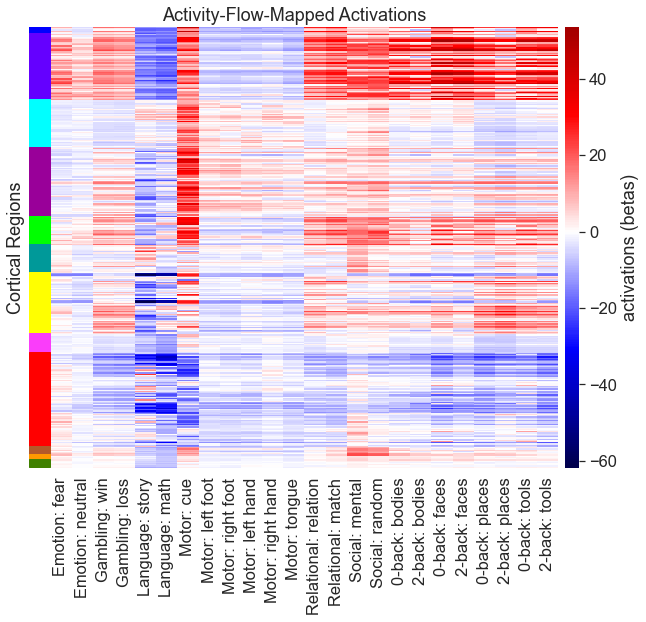

In [65]:
# Visualize actual activations: MMP regions sorted on y-axis by CAB-NP network
# Mean across subjects 

################################################################################
# Initialize some variables 
buffSize = 1
matrixHere = np.nanmean(predicted_activations,axis=2)[node_order,:]
xTicks = np.arange(num_conditions) + buffSize + 0.5
xTickLabels = task_conditions
yTickLabels = []

################################################################################
# Make room in matrix for network axis labels, which will be filled in with color 'patches'
topSize = (num_parcels,buffSize)
topBuff = np.zeros((topSize))
topBuff = (topBuff + 1) * 0.31
matWithBuffer = np.hstack((topBuff,matrixHere))

################################################################################
# Draw figure 
sns.set(font_scale=1.5)
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10,7))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
pH = sns.heatmap(matWithBuffer,center=0,cmap='seismic',
                 cbar_kws={'label':'activations (betas)','pad':0.01,'aspect':30},
                 yticklabels=yTickLabels,xticklabels=xTickLabels)
plt.subplots_adjust(left=None,bottom=None,right=1,top=1,wspace=1,hspace=1)
ax.set_xticks(xTicks)
ax.set_xticklabels(task_conditions,rotation=90)

################################################################################
# Add network colors labels on y-axis as patches 
for net in range(num_nets):
    netSize = int(boundaries_CA[net,2])
    netStart = int(boundaries_CA[net,0])
    rectV = patches.Rectangle((0,netStart-1),buffSize,netSize,linewidth=1,
                              edgecolor=color_list[net],facecolor=color_list[net])
    ax.add_patch(rectV)
    
rectWhite = patches.Rectangle((num_parcels-1,num_conditions-1),buffSize,buffSize,
                              linewidth=1,edgecolor='white',facecolor='white')
ax.add_patch(rectWhite)

################################################################################
# Plot labels and show 
plt.title('Activity-Flow-Mapped Activations')
plt.ylabel('Cortical Regions')
plt.show()

################################################################################
# Save 
figName = figures_dir + 'activity_flow_mapped_activations_all_conditions_subject_means.png'
fig.savefig(figName,bbox_inches='tight',format='png',dpi=600)

# Preliminary analyses

## Response profiles

In [68]:
# Accuracy of activty-flow-mapped response profiles
# ie, cross-condition (all 24 HCP conditions) responses of each functional complex
# NOTE: showing right hemisphere results here only for demo purposes 

# DATA 
num_complexes = 4 
numROIsPerComplex = [5,3,7,6]
actualArray = actual_activations.copy()
predictedArray = predicted_activations.copy()
parcelOfInterest_All_LEFT = parcelOfInterest_All[:21]
parcelOfInterest_All_RIGHT = parcelOfInterest_All[21:]

# EXTRACT FUNCTIONAL COMPLEX DATA 
initIx = 0
actDataComplexes = np.zeros((num_complexes,num_conditions,num_subjs))
predDataComplexes = np.zeros((num_complexes,num_conditions,num_subjs))
for complexNum in range(num_complexes):
    numROIsHere = numROIsPerComplex[complexNum]
    startNode = initIx
    endNode = startNode + numROIsHere
    initIx = endNode
    nodesHere = parcelOfInterest_All_RIGHT[startNode:endNode]
    actDataComplexes[complexNum,:,:] = np.nanmean(actualArray[nodesHere,:,:],axis=0)
    predDataComplexes[complexNum,:,:] = np.nanmean(predictedArray[nodesHere,:,:],axis=0)
    
# PREDICTION ACCURACY MEASURES
pearsRvals = np.zeros((num_complexes,num_subjs))
coefDet = np.zeros((num_complexes,num_subjs))
mae = np.zeros((num_complexes,num_subjs))
for subjNum in range(num_subjs):
    for nodeNum in range(num_complexes): 
        thisAct = actDataComplexes[nodeNum,:,subjNum]
        thisPred = predDataComplexes[nodeNum,:,subjNum]
        pearsRvals[nodeNum,subjNum] = np.corrcoef(thisAct,thisPred)[0,1]
        coefDet[nodeNum,subjNum] = sklearn.metrics.r2_score(thisAct,thisPred)
        mae[nodeNum,subjNum] = np.nanmean(np.abs(np.subtract(thisAct,thisPred)))
        
# PRINT RESULTS
print('Condition-wise prediction accuracy, right hemisphere (compare 24 '+
      'conditions then avg. across 4 complexes and n=20 subjects)...')
print('Pearsons r = ' + str(np.round(np.nanmean(pearsRvals),2)));
print('Coeff. of determination R^2 = ' + str(np.round(np.nanmean(coefDet),2)))
print('MAE = ' + str(np.round(np.nanmean(mae),2)))

Condition-wise prediction accuracy, right hemisphere (compare 24 conditions then avg. across 4 complexes and n=20 subjects)...
Pearsons r = 0.94
Coeff. of determination R^2 = 0.83
MAE = 4.04


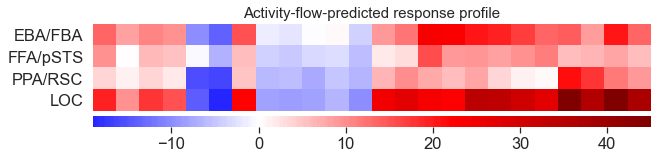

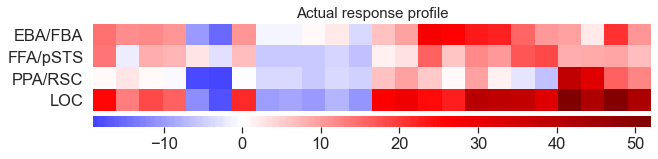

In [71]:
# Visualize response profiles (right hemisphere)

# Modify condition order so that 0-back and 2-back are next to each other visually 
condOrder = [0, 1, 2, 3, 4, 5, 
             6, 7, 8, 9, 10, 11, 
             12, 13, 14, 15, 16, 
             20, 17, 21, 18, 22, 19, 23]
yLabels = ['EBA/FBA','FFA/pSTS','PPA/RSC','LOC']

figW = 10
figH = 2
numYTicks = 4
yTicks = np.arange(4) + 0.5
yTickLabels = yLabels
numXTicks = 24
xTicks = [1,2,3]
xTickLabels = []

##################################################################
# Predicted
initIx = 0
predDataModROIs = np.nanmean(predicted_activations,axis=2)[parcelOfInterest_All_RIGHT,:]
predDataModROIsAVG = np.zeros((num_complexes,num_conditions))
for complexNum in range(num_complexes):
    numROIsHere = numROIsPerComplex[complexNum]
    startNode = initIx
    endNode = startNode + numROIsHere
    initIx = endNode
    nodesHere = parcelOfInterest_All_RIGHT[startNode:endNode]
    predDataModROIsAVG[complexNum,:] = np.nanmean(np.nanmean(predicted_activations,axis=2)
                                                  [nodesHere,:],axis=0); 

predDataModROIsAVG = predDataModROIsAVG[:,condOrder]
vMinD = round(np.min(predDataModROIsAVG))
vMaxD = round(np.max(predDataModROIsAVG))

plt.rcParams['font.size'] = 19
fig, ax = plt.subplots(1,figsize=(figW,figH))
p = sns.heatmap(predDataModROIsAVG,center=0,cmap='seismic',
                cbar=True,yticklabels=yTickLabels,xticklabels=xTickLabels,ax=ax,
                cbar_kws={'pad':0.05,'aspect':50,'orientation':'horizontal'},
                vmin=vMinD,vmax=vMaxD)
ax.set_yticks(yTicks)
ax.set_xticks(xTicks)
plt.title('Activity-flow-predicted response profile',fontsize=15)
plt.show()

# Save
figName = figures_dir + 'activity_flow_mapped_activations_response_profile_subject_means.png'
fig.savefig(figName,bbox_inches='tight',format='png',dpi=600)

##################################################################
# Actual 
initIx = 0
actDataModROIs = np.nanmean(actual_activations,axis=2)[parcelOfInterest_All_RIGHT,:]
actDataModROIsAVG = np.zeros((num_complexes,num_conditions))
for complexNum in range(num_complexes):
    numROIsHere = numROIsPerComplex[complexNum]
    startNode = initIx
    endNode = startNode + numROIsHere
    initIx = endNode
    nodesHere = parcelOfInterest_All_RIGHT[startNode:endNode]
    actDataModROIsAVG[complexNum,:] = np.nanmean(np.nanmean(actual_activations,axis=2)
                                                 [nodesHere,:],axis=0)

actDataModROIsAVG = actDataModROIsAVG[:,condOrder]
vMinD = round(np.min(actDataModROIsAVG))
vMaxD = round(np.max(actDataModROIsAVG))

plt.rcParams['font.size'] = 19
fig, ax = plt.subplots(1,figsize=(figW,figH))
p = sns.heatmap(actDataModROIsAVG,center=0,cmap='seismic',cbar=True,
                yticklabels=yTickLabels,xticklabels=xTickLabels,ax=ax,
                cbar_kws={'pad':0.05,'aspect':50,'orientation':'horizontal'},
                vmin=vMinD,vmax=vMaxD)
ax.set_yticks(yTicks)
ax.set_xticks(xTicks)
plt.title('Actual response profile',fontsize=15)
plt.show()

# Save
figName = figures_dir + 'actual_activations_response_profile_subject_means.png'
fig.savefig(figName,bbox_inches='tight',format='png',dpi=600)

## Whole-cortex activity flow mapping, per visual category

In [72]:
# PRINT CORE RESULTS
numCatsHere = 4

print('Whole-cortex activity flow prediction accuracies, '+ 
      'per visual category. Compare across-subjects, then ' + 
      'average (i.e., cross-node)...\n');

# Note: specifications below correspond to variables in condStrLong 
# (standard ordering for conditions in HCP S1200 dataset)
rVals = np.zeros((num_subjs,numCatsHere))
rsqVals = np.zeros((num_subjs,numCatsHere))
maeVals = np.zeros((num_subjs,numCatsHere))
for catNum in range(numCatsHere): 
    if catNum==0:
        condIxsCat = [16,20]
        condIxsNonCat = [17,18,19,21,22,23]
        catStrHere = 'BODY'
    elif catNum==1:
        condIxsCat = [17,21]
        condIxsNonCat = [16,18,19,20,22,23]
        catStrHere = 'FACE'
        print(' ')
    elif catNum==2:
        condIxsCat = [18,22]
        condIxsNonCat = [16,17,19,20,21,23]
        catStrHere = 'PLACE'
        print(' ');
    elif catNum==3:
        condIxsCat = [19,23]
        condIxsNonCat = [16,17,18,20,21,22]
        catStrHere = 'TOOLS'
        print(' ')
    
    for subjNum in range(num_subjs):
        actData = np.nanmean(actual_activations[:,condIxsCat,subjNum],axis=1).copy()
        predData = np.nanmean(predicted_activations[:,condIxsCat,subjNum],axis=1).copy()
        
        rVals[subjNum,catNum] = np.corrcoef(actData,predData)[0,1]
        rsqVals[subjNum,catNum] = sklearn.metrics.r2_score(actData,predData)
        maeVals[subjNum,catNum] = np.nanmean(np.abs(np.subtract(actData,predData)))
        
    print('Prediction accuracy for ' + catStrHere + 
          ' category conditions in pearsons r = ' + 
          str(np.round(np.nanmean(rVals[:,catNum]),2)))
    print('Prediction accuracy for ' + catStrHere + 
          ' category conditions in coeficient of determination, R-sq = ' + 
          str(np.round(np.nanmean(rsqVals[:,catNum]),2)))
    print('Prediction accuracy for ' + catStrHere + 
          ' category conditions in mean absolute error, MAE = ' + 
          str(np.round(np.nanmean(maeVals[:,catNum]),2)))


Whole-cortex activity flow prediction accuracies, per visual category. Compare across-subjects, then average (i.e., cross-node)...

Prediction accuracy for BODY category conditions in pearsons r = 0.89
Prediction accuracy for BODY category conditions in coeficient of determination, R-sq = 0.77
Prediction accuracy for BODY category conditions in mean absolute error, MAE = 5.54
 
Prediction accuracy for FACE category conditions in pearsons r = 0.85
Prediction accuracy for FACE category conditions in coeficient of determination, R-sq = 0.7
Prediction accuracy for FACE category conditions in mean absolute error, MAE = 6.29
 
Prediction accuracy for PLACE category conditions in pearsons r = 0.88
Prediction accuracy for PLACE category conditions in coeficient of determination, R-sq = 0.76
Prediction accuracy for PLACE category conditions in mean absolute error, MAE = 6.6
 
Prediction accuracy for TOOLS category conditions in pearsons r = 0.89
Prediction accuracy for TOOLS category conditions

## Benchmark responsiveness

In [ ]:
# Benchmark analyses to corroborate that functional complexes
# identified in the literature are responsive to their corresponding
# visual category, and that the activity flow mapped 
# responses are as well.

In [89]:
# BODIES COMPLEX (right hemisphere results demonstrated here)
# Benchmarking t-test: is bodies > non-bodes in EBA/FBA? 

# Variables specific to bodies: 
parcelOfInterestR = parcelOfInterestR_body
parcelOfInterestL = parcelOfInterestL_body
condIxsCat = [16,20]
condIxsNonCat = [17,18,19,21,22,23]
catStrHere = 'bodies'

##########################################################################################
# DATA 
actData = actual_activations.copy()
predData = predicted_activations.copy()
complexAct_RightBody = actData[parcelOfInterestR,:,:]
complexPred_RightBody = predData[parcelOfInterestR,:,:]
complexAct_LeftBody = actData[parcelOfInterestL,:,:]
complexPred_LeftBody = predData[parcelOfInterestL,:,:]

##########################################################################################
# NOTE: these results are saved into a p-value matrix that continues 
# through bodies-tools sections (see below) --> FDR correction
# Use the below dict for reference: pMatStrs[row][col]
pMatStrs = [['bodies_actual_right','bodies_predicted_right',
             'bodies_actual_left','bodies_predicted_left'],
            ['faces_actual_right','faces_predicted_right',
             'faces_actual_left','faces_predicted_left'],
            ['places_actual_right','places_predicted_right',
             'places_actual_left','places_predicted_left'],
            ['tools_actual_right','tools_predicted_right',
             'tools_actual_left','tools_predicted_left']]

# rows = bodies,faces,places,tools. 
# colums = actual-right, predicted-right, actual-left, predicted-left 
pMat = np.zeros((num_complexes,4))
tMat = np.zeros((num_complexes,4))

##########################################################################################
# ACTUAL 
tValR,pValR = stats.ttest_rel(np.nanmean(np.nanmean(complexAct_RightBody
                                                    [:,condIxsCat,:],axis=0),axis=0),
                              np.nanmean(np.nanmean(complexAct_RightBody
                                                    [:,condIxsNonCat,:],axis=0),axis=0))
tValL,pValL = stats.ttest_rel(np.nanmean(np.nanmean(complexAct_LeftBody
                                                    [:,condIxsCat,:],axis=0),axis=0),
                              np.nanmean(np.nanmean(complexAct_LeftBody
                                                    [:,condIxsNonCat,:],axis=0),axis=0))
print('RIGHT HEMISPHERE, ACTUAL: ' + catStrHere + ' > NON-' + catStrHere + 
      ': t(' +str(num_subjs)+ ') = ' + str(np.round(tValR,2)) + ', p = ' + str(pValR/2))
print('LEFT HEMISPHERE, ACTUAL: ' + catStrHere + ' > NON-' + catStrHere + 
      ': t(' +str(num_subjs)+ ') = ' + str(np.round(tValL,2)) + ', p = ' + str(pValL/2))
pMat[0,0] = pValR/2
pMat[0,2] = pValL/2
tMat[0,0] = tValR
tMat[0,2] = tValL
##########################################################################################
# PREDICTED 
tValR,pValR = stats.ttest_rel(np.nanmean(np.nanmean(complexPred_RightBody
                                                    [:,condIxsCat,:],axis=0),axis=0),
                              np.nanmean(np.nanmean(complexPred_RightBody
                                                    [:,condIxsNonCat,:],axis=0),axis=0))
tValL,pValL = stats.ttest_rel(np.nanmean(np.nanmean(complexPred_LeftBody
                                                    [:,condIxsCat,:],axis=0),axis=0),
                              np.nanmean(np.nanmean(complexPred_LeftBody
                                                    [:,condIxsNonCat,:],axis=0),axis=0))
print('\nRIGHT HEMISPHERE, PREDICTED: ' + catStrHere + ' > NON-' + catStrHere + 
      ': t(' +str(num_subjs)+ ') = ' + str(np.round(tValR,2)) + ', p = ' + str(pValR/2))
print('LEFT HEMISPHERE, PREDICTED: ' + catStrHere + ' > NON-' + catStrHere + 
      ': t(' +str(num_subjs)+ ') = ' + str(np.round(tValL,2)) + ', p = ' + str(pValL/2))
pMat[0,1] = pValR/2
pMat[0,3] = pValL/2
tMat[0,1] = tValR
tMat[0,3] = tValL

RIGHT HEMISPHERE, ACTUAL: bodies > NON-bodies: t(20) = 9.58, p = 5.201137812357928e-09
LEFT HEMISPHERE, ACTUAL: bodies > NON-bodies: t(20) = 6.79, p = 8.693031091443229e-07

RIGHT HEMISPHERE, PREDICTED: bodies > NON-bodies: t(20) = 5.7, p = 8.475255800318826e-06
LEFT HEMISPHERE, PREDICTED: bodies > NON-bodies: t(20) = 4.32, p = 0.00018620235584023467


Actual...


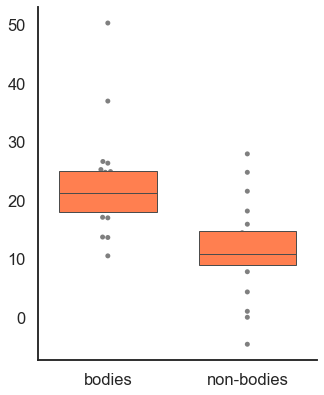


Activity-flow-mapped...


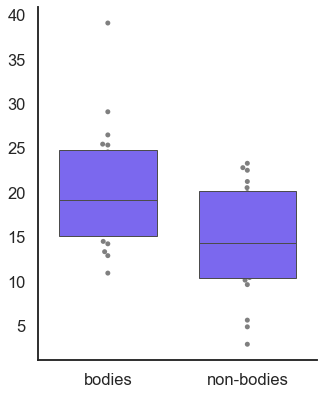

In [90]:
# VISUALIZE: bodies complex & body conditions, right hemisphere
# NOTE: only visualizing bodies complex in this notebook, but code can be adapted for all categories below

taskOfInterest = taskOfInterest_body # can be changed
taskListShort = np.array([0,1,2,3])
nonTaskIxsShort = np.where(taskListShort!=taskOfInterest)[0]
dotColor = "black"
alphaVal = 0.5
sizeVal = 5
figW = 5
figHe = 6.5

################################################################################
# ACTUAL - 2 contrast
print('Actual...')
faceColorAct = 'coral'
actDataWMR = np.nanmean(np.reshape(np.nanmean(complexAct_RightBody,axis=0)
                                   [16:,:],(2,4,num_subjs)),axis=0)
dataActualR = {catStrHere:actDataWMR[taskOfInterest,:],
               'non-'+catStrHere:np.nanmean(actDataWMR[nonTaskIxsShort,:],axis=0)}
dfActualR = pd.DataFrame(dataActualR)
sns.set(style="white")
sns.set_context("talk")
figH, axH = plt.subplots(figsize=(figW,figHe))
sns.despine(fig=figH,top=True,right=True,bottom=False,
            left=False,offset=None,trim=False,ax=axH)
sns.swarmplot(data=dfActualR, color=dotColor, zorder=0, 
              size=sizeVal, alpha=alphaVal)
sns.boxplot(data=dfActualR,showfliers=False,showcaps=False,
            whiskerprops={'linewidth':0},boxprops={'facecolor':faceColorAct},
            linewidth=1,width=0.7)
plt.show()

# Save
figName = figures_dir + 'actual_benchmark_bodies.png'
figH.savefig(figName,bbox_inches='tight',format='png',dpi=600)

################################################################################
# PREDICTED  - 2 contrast 
print('\nActivity-flow-mapped...')
faceColorAct = 'mediumslateblue'
actDataWMR = np.nanmean(np.reshape(np.nanmean(complexPred_RightBody,axis=0)
                                   [16:,:],(2,4,num_subjs)),axis=0)
dataActualR = {catStrHere:actDataWMR[taskOfInterest,:],
               'non-'+catStrHere:np.nanmean(actDataWMR[nonTaskIxsShort,:],axis=0)}
dfActualR = pd.DataFrame(dataActualR)

sns.set(style="white")
sns.set_context("talk")
figH, axH = plt.subplots(figsize=(figW,figHe))
sns.despine(fig=figH,top=True,right=True,bottom=False,left=False,
            offset=None,trim=False,ax=axH)
sns.swarmplot(data=dfActualR, color=dotColor, zorder=0, 
              size=sizeVal, alpha=alphaVal)
sns.boxplot(data=dfActualR,showfliers=False,showcaps=False,
            whiskerprops={'linewidth':0},boxprops={'facecolor':faceColorAct},
            linewidth=1,width=0.7)
plt.show()

# Save
figName = figures_dir + 'activity_flow_mapped_benchmark_bodies.png'
figH.savefig(figName,bbox_inches='tight',format='png',dpi=600)

In [83]:
# FACES COMPLEX (right hemisphere results demonstrated here)
# Benchmarking t-test: is faces > non-faces in FFA/pSTS? 

# Variables specific to faces: 
parcelOfInterestR = parcelOfInterestR_face
parcelOfInterestL = parcelOfInterestL_face
condIxsCat = [17,21]
condIxsNonCat = [16,18,19,20,22,23]
catStrHere = 'faces'

##########################################################################################
# DATA 
complexAct_RightFace = actData[parcelOfInterestR,:,:]
complexPred_RightFace = predData[parcelOfInterestR,:,:]
complexAct_LeftFace = actData[parcelOfInterestL,:,:]
complexPred_LeftFace = predData[parcelOfInterestL,:,:]

##########################################################################################
# ACTUAL 
tValR,pValR = stats.ttest_rel(np.nanmean(np.nanmean(complexAct_RightFace
                                                    [:,condIxsCat,:],axis=0),axis=0),
                              np.nanmean(np.nanmean(complexAct_RightFace
                                                    [:,condIxsNonCat,:],axis=0),axis=0))
tValL,pValL = stats.ttest_rel(np.nanmean(np.nanmean(complexAct_LeftFace
                                                    [:,condIxsCat,:],axis=0),axis=0),
                              np.nanmean(np.nanmean(complexAct_LeftFace
                                                    [:,condIxsNonCat,:],axis=0),axis=0))
print('RIGHT HEMISPHERE, ACTUAL: ' + catStrHere + ' > NON-' + catStrHere + 
      ': t(' +str(num_subjs)+ ') = ' + str(np.round(tValR,2)) + ', p = ' + str(pValR/2))
print('LEFT HEMISPHERE, ACTUAL: ' + catStrHere + ' > NON-' + catStrHere + 
      ': t(' +str(num_subjs)+ ') = ' + str(np.round(tValL,2)) + ', p = ' + str(pValL/2))
pMat[1,0] = pValR/2
pMat[1,2] = pValL/2
tMat[1,0] = tValR
tMat[1,2] = tValL

##########################################################################################
# PREDICTED 
tValR,pValR = stats.ttest_rel(np.nanmean(np.nanmean(complexPred_RightFace
                                                    [:,condIxsCat,:],axis=0),axis=0),
                              np.nanmean(np.nanmean(complexPred_RightFace
                                                    [:,condIxsNonCat,:],axis=0),axis=0))
tValL,pValL = stats.ttest_rel(np.nanmean(np.nanmean(complexPred_LeftFace
                                                    [:,condIxsCat,:],axis=0),axis=0),
                              np.nanmean(np.nanmean(complexPred_LeftFace
                                                    [:,condIxsNonCat,:],axis=0),axis=0))
print('\nRIGHT HEMISPHERE, PREDICTED: ' + catStrHere + ' > NON-' + catStrHere + 
      ': t(' +str(num_subjs)+ ') = ' + str(np.round(tValR,2)) + ', p = ' + str(pValR/2))
print('LEFT HEMISPHERE, PREDICTED: ' + catStrHere + ' > NON-' + catStrHere + 
      ': t(' +str(num_subjs)+ ') = ' + str(np.round(tValL,2)) + ', p = ' + str(pValL/2))
pMat[1,1] = pValR/2
pMat[1,3] = pValL/2
tMat[1,1] = tValR
tMat[1,3] = tValL

RIGHT HEMISPHERE, ACTUAL: faces > NON-faces: t(20) = 7.68, p = 1.521562053999964e-07
LEFT HEMISPHERE, ACTUAL: faces > NON-faces: t(20) = 6.42, p = 1.8506828514304489e-06

RIGHT HEMISPHERE, PREDICTED: faces > NON-faces: t(20) = 3.73, p = 0.0007126710636680405
LEFT HEMISPHERE, PREDICTED: faces > NON-faces: t(20) = 3.79, p = 0.0006207060483614838


In [84]:
# PLACES COMPLEX (right hemisphere results demonstrated here)
# Benchmarking t-test: is places > non-places in PPA/RSC? 

# Variables specific to places: 
parcelOfInterestR = parcelOfInterestR_place
parcelOfInterestL = parcelOfInterestL_place
condIxsCat = [18,22]
condIxsNonCat = [16,17,19,20,21,23]
catStrHere = 'places'

##########################################################################################
# DATA 
complexAct_RightPlace = actData[parcelOfInterestR,:,:]
complexPred_RightPlace = predData[parcelOfInterestR,:,:]
complexAct_LeftPlace = actData[parcelOfInterestL,:,:]
complexPred_LeftPlace = predData[parcelOfInterestL,:,:]

##########################################################################################
# ACTUAL 
tValR,pValR = stats.ttest_rel(np.nanmean(np.nanmean(complexAct_RightPlace
                                                    [:,condIxsCat,:],axis=0),axis=0),
                              np.nanmean(np.nanmean(complexAct_RightPlace
                                                    [:,condIxsNonCat,:],axis=0),axis=0))
tValL,pValL = stats.ttest_rel(np.nanmean(np.nanmean(complexAct_LeftPlace
                                                    [:,condIxsCat,:],axis=0),axis=0),
                              np.nanmean(np.nanmean(complexAct_LeftPlace
                                                    [:,condIxsNonCat,:],axis=0),axis=0))
print('RIGHT HEMISPHERE, ACTUAL: ' + catStrHere + ' > NON-' + catStrHere + 
      ': t(' +str(num_subjs)+ ') = ' + str(np.round(tValR,2)) + ', p = ' + str(pValR/2))
print('LEFT HEMISPHERE, ACTUAL: ' + catStrHere + ' > NON-' + catStrHere + 
      ': t(' +str(num_subjs)+ ') = ' + str(np.round(tValL,2)) + ', p = ' + str(pValL/2))
pMat[2,0] = pValR/2
pMat[2,2] = pValL/2
tMat[2,0] = tValR
tMat[2,2] = tValL

##########################################################################################
# PREDICTED 
tValR,pValR = stats.ttest_rel(np.nanmean(np.nanmean(complexPred_RightPlace
                                                    [:,condIxsCat,:],axis=0),axis=0),
                              np.nanmean(np.nanmean(complexPred_RightPlace
                                                    [:,condIxsNonCat,:],axis=0),axis=0))
tValL,pValL = stats.ttest_rel(np.nanmean(np.nanmean(complexPred_LeftPlace
                                                    [:,condIxsCat,:],axis=0),axis=0),
                              np.nanmean(np.nanmean(complexPred_LeftPlace
                                                    [:,condIxsNonCat,:],axis=0),axis=0))
print('\nRIGHT HEMISPHERE, PREDICTED: ' + catStrHere + ' > NON-' + catStrHere + 
      ': t(' +str(num_subjs)+ ') = ' + str(np.round(tValR,2)) + ', p = ' + str(pValR/2))
print('LEFT HEMISPHERE, PREDICTED: ' + catStrHere + ' > NON-' + catStrHere + 
      ': t(' +str(num_subjs)+ ') = ' + str(np.round(tValL,2)) + ', p = ' + str(pValL/2))
pMat[2,1] = pValR/2
pMat[2,3] = pValL/2
tMat[2,1] = tValR
tMat[2,3] = tValL

RIGHT HEMISPHERE, ACTUAL: places > NON-places: t(20) = 13.99, p = 9.28882943023885e-12
LEFT HEMISPHERE, ACTUAL: places > NON-places: t(20) = 13.07, p = 3.0134677119758074e-11

RIGHT HEMISPHERE, PREDICTED: places > NON-places: t(20) = 10.74, p = 8.1735720191906e-10
LEFT HEMISPHERE, PREDICTED: places > NON-places: t(20) = 10.51, p = 1.1695608045708595e-09


In [85]:
# TOOLS COMPLEX (right hemisphere results demonstrated here)
# Benchmarking t-test: is tools > non-tools in LOC? 

# Variables specific to tools: 
parcelOfInterestR = parcelOfInterestR_tool
parcelOfInterestL = parcelOfInterestL_tool
condIxsCat = [19,23]
condIxsNonCat = [16,17,18,20,21,22]
catStrHere = 'tools'

##########################################################################################
# DATA 
complexAct_RightTool = actData[parcelOfInterestR,:,:]
complexPred_RightTool = predData[parcelOfInterestR,:,:]
complexAct_LeftTool = actData[parcelOfInterestL,:,:]
complexPred_LeftTool = predData[parcelOfInterestL,:,:]

##########################################################################################
# ACTUAL 
tValR,pValR = stats.ttest_rel(np.nanmean(np.nanmean(complexAct_RightTool
                                                    [:,condIxsCat,:],axis=0),axis=0),
                              np.nanmean(np.nanmean(complexAct_RightTool
                                                    [:,condIxsNonCat,:],axis=0),axis=0))
tValL,pValL = stats.ttest_rel(np.nanmean(np.nanmean(complexAct_LeftTool
                                                    [:,condIxsCat,:],axis=0),axis=0),
                              np.nanmean(np.nanmean(complexAct_LeftTool
                                                    [:,condIxsNonCat,:],axis=0),axis=0))
print('RIGHT HEMISPHERE, ACTUAL: ' + catStrHere + ' > NON-' + catStrHere + 
      ': t(' +str(num_subjs)+ ') = ' + str(np.round(tValR,2)) + ', p = ' + str(pValR/2))
print('LEFT HEMISPHERE, ACTUAL: ' + catStrHere + ' > NON-' + catStrHere + 
      ': t(' +str(num_subjs)+ ') = ' + str(np.round(tValL,2)) + ', p = ' + str(pValL/2))
pMat[3,0] = pValR/2
pMat[3,2] = pValL/2
tMat[3,0] = tValR
tMat[3,2] = tValL

##########################################################################################
# PREDICTED 
tValR,pValR = stats.ttest_rel(np.nanmean(np.nanmean(complexPred_RightTool
                                                    [:,condIxsCat,:],axis=0),axis=0),
                              np.nanmean(np.nanmean(complexPred_RightTool
                                                    [:,condIxsNonCat,:],axis=0),axis=0))
tValL,pValL = stats.ttest_rel(np.nanmean(np.nanmean(complexPred_LeftTool
                                                    [:,condIxsCat,:],axis=0),axis=0),
                              np.nanmean(np.nanmean(complexPred_LeftTool
                                                    [:,condIxsNonCat,:],axis=0),axis=0))
print('\nRIGHT HEMISPHERE, PREDICTED: ' + catStrHere + ' > NON-' + catStrHere + 
      ': t(' +str(num_subjs)+ ') = ' + str(np.round(tValR,2)) + ', p = ' + str(pValR/2))
print('LEFT HEMISPHERE, PREDICTED: ' + catStrHere + ' > NON-' + catStrHere + 
      ': t(' +str(num_subjs)+ ') = ' + str(np.round(tValL,2)) + ', p = ' + str(pValL/2))
pMat[3,1] = pValR/2
pMat[3,3] = pValL/2
tMat[3,1] = tValR
tMat[3,3] = tValL

RIGHT HEMISPHERE, ACTUAL: tools > NON-tools: t(20) = 4.81, p = 6.144865676766105e-05
LEFT HEMISPHERE, ACTUAL: tools > NON-tools: t(20) = 7.32, p = 3.0547891054190783e-07

RIGHT HEMISPHERE, PREDICTED: tools > NON-tools: t(20) = 5.62, p = 1.0107564609885997e-05
LEFT HEMISPHERE, PREDICTED: tools > NON-tools: t(20) = 7.71, p = 1.4478232496822781e-07


In [87]:
## FDR CORRECTION OF ALL THE T-TESTS ABOVE 
# (adapted from: https://warwick.ac.uk/fac/sci/statistics/staff/academic-research/nichols/software/fdr/fdrm/)

print('FDR correction for all benchmark tests (16 total)...\n'); 

pVec = np.reshape(pMat,(4*4))
pVals = np.sort(pVec)
oIx = np.argsort(pVec)
oIxR = np.argsort(oIx)
numP = pVec.shape[0]
qVal = 0.05
ixList = np.arange(0,numP) + 1
thrLine = (ixList * qVal)/numP
threshVal = np.max(pVals[pVals<=thrLine])

if threshVal==0:
    threshVal = np.max(thrLine[pVals<=thrLine])
if threshVal.size==0: 
    threshVal = 0
    
print('New threshold (FDR corrected) = ' + str(threshVal) + '\n')
pCorr = (pVals*numP)/ixList
pCorrOrigSorting = pCorr[oIxR]
pAdj = np.zeros((numP))
invVec = np.flip(np.arange(0,numP)+1)
prevVal = 1
for pV in range(numP):
    thisIx = invVec[pV]
    pAdj[thisIx-1] = np.min([prevVal,pVals[thisIx-1]*numP/thisIx])
    prevVal = pAdj[thisIx-1]
    
pAdjOrigSorting = pAdj[oIxR]
sigVec = pAdjOrigSorting<=threshVal
sigMat = np.reshape(sigVec,(4,4))
pAdjOrigSortingMat = np.reshape(pAdjOrigSorting,(4,4))
for rowNum in range(4):
    for colNum in range(4): 
        thisTestStr = pMatStrs[rowNum][colNum]
        if sigMat[rowNum,colNum]:
            sigStr = 'significant'
        elif not sigMat[rowNum,colNum]:
            sigStr = 'not significant'
        if colNum==3:
            strSpc = '\n'
        else: 
            strSpc = ''
        pValHere = pAdjOrigSortingMat[rowNum,colNum]
        print('Test of ' + thisTestStr + ': t(' + str(num_subjs) + 
              ') = ' + str(np.round(tMat[rowNum,colNum],2)) + 
              ', p (FDR-adjusted) = ' + str('{:0.2e}'.format(pValHere)) 
              + ' ---> ' + sigStr + strSpc)


FDR correction for all benchmark tests (16 total)...

New threshold (FDR corrected) = 0.0007126710636680405

Test of bodies_actual_right: t(20) = 9.58, p (FDR-adjusted) = 1.66e-08 ---> significant
Test of bodies_predicted_right: t(20) = 5.7, p (FDR-adjusted) = 1.23e-05 ---> significant
Test of bodies_actual_left: t(20) = 6.79, p (FDR-adjusted) = 1.55e-06 ---> significant
Test of bodies_predicted_left: t(20) = 4.32, p (FDR-adjusted) = 2.13e-04 ---> significant

Test of faces_actual_right: t(20) = 7.68, p (FDR-adjusted) = 3.48e-07 ---> significant
Test of faces_predicted_right: t(20) = 3.73, p (FDR-adjusted) = 7.13e-04 ---> significant
Test of faces_actual_left: t(20) = 6.42, p (FDR-adjusted) = 2.96e-06 ---> significant
Test of faces_predicted_left: t(20) = 3.79, p (FDR-adjusted) = 6.62e-04 ---> significant

Test of places_actual_right: t(20) = 13.99, p (FDR-adjusted) = 1.49e-10 ---> significant
Test of places_predicted_right: t(20) = 10.74, p (FDR-adjusted) = 4.36e-09 ---> significant
T

# Category selectivity 

In [ ]:
# NOTE: only demonstrating body images model below for space considerations.
# The below code can be adapted accordingly for the other 3 models from 
# the manuscript, or your own data as researchers see fit. 

# Or contact Carrisa for more information/code for faces, places, tools models.
# carrisacocuzza@gmail.com

Actual category selectivity to images of bodies in the right hemisphere EBA & FBA (cross-subject mean) = 1.67
Compared to null mean of 1: t(18) = 6.3, p = 6.13e-06

Predicted category selectivity to images of bodies in the right hemisphere EBA & FBA (cross-subject mean) = 1.43
Compared to null mean of 1: t(18) = 4.65, p = 1.98e-04

Distributed processing contribution to category selectivity to images of bodies in the right hemisphere EBA & FBA (cross-subject mean) = 85.58%


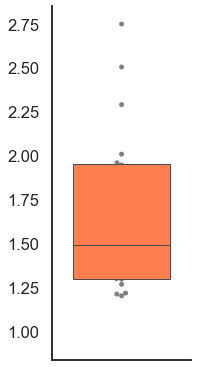

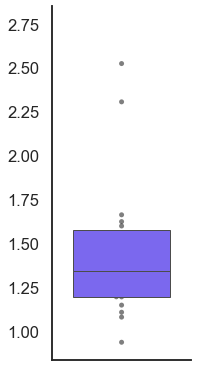

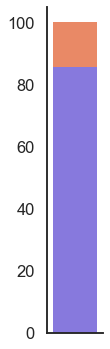

Percent predicted = 85.57980045572411%

RIGHT HEMISPHERE: across actual and predicted there were 1 outlier subjects removed, subject indices: [12]


In [92]:
# BODIES COMPLEX (right hemisphere only for demo purposes)

##########################################################################################
# DATA 
actData = actual_activations.copy()
predData = predicted_activations.copy()

taskOfInterest = 0
category_indices = [16,20]
noncategory_indices = [17,18,19,21,22,23]
catStrHere = 'bodies'
wmIxsCat = [0, 4]
wmIxsNonCat = [1, 2, 3, 5, 6, 7]
parcelStrLong = 'EBA & FBA'
parcelOfInterestR = [181, 315, 317, 335, 336]
parcelStrR = 'rmodBC'
predDataHereR = predData[parcelOfInterestR,:,:].copy()
actDataHereR = actData[parcelOfInterestR,:,:].copy()
taskListShort = np.array([0,1,2,3])
nonTaskIxsShort = np.where(taskListShort!=taskOfInterest)[0]

#########################################################################
# Variables for min/max normalization and outlier handling (see manuscript Methods)
minVal = 0
maxVal = 1
numDevs = 5

# whether to use outliers across both actual and predicted sets together (ie nonoverlapping/unique) 
# (recommended so % distributed has same # subjects in numerator and denominator)
useBothSets = True

#############################################################################
# RIGHT HEMISPHERE 
csActAll,csPredAll,csActArr,csPredArr=cs.category_selectivity(actDataHereR,predDataHereR,category_indices,
                                                              noncategory_indices,norm_method='min-max',
                                                              min_val=minVal,max_val=maxVal,hcp_nbacks=True)

outsAct,outsPred,outsBoth,madPosA,madNegA,madPosP,madNegP=soh.selectivity_outlier_handling(csActAll,csPredAll,
                                                                                           bidirectional=True,
                                                                                           num_devs=numDevs)

predMetricSubjs_ModR = csPredAll.copy()
actMetricSubjs_ModR = csActAll.copy()
if not useBothSets:
    predMetricSubjs_ModR = np.delete(predMetricSubjs_ModR,outsPred)
    actMetricSubjs_ModR = np.delete(actMetricSubjs_ModR,outsAct)
elif useBothSets:
    predMetricSubjs_ModR = np.delete(predMetricSubjs_ModR,outsBoth)
    actMetricSubjs_ModR = np.delete(actMetricSubjs_ModR,outsBoth)

distPercR = (np.nanmean(predMetricSubjs_ModR)/np.nanmean(actMetricSubjs_ModR)) * 100
dataActualR = {catStrHere:actMetricSubjs_ModR}
dfActualR = pd.DataFrame(dataActualR)
dataPredR = {catStrHere:predMetricSubjs_ModR}
dfPredR = pd.DataFrame(dataPredR)

##########################################################################
# RESULTS
percPredMeanR = distPercR

hypoMean = 1
tValActR,pValActR = stats.ttest_1samp(actMetricSubjs_ModR,hypoMean)
tValPredR,pValPredR = stats.ttest_1samp(predMetricSubjs_ModR,hypoMean)

print('Actual category selectivity to images of ' + catStrHere + 
      ' in the right hemisphere ' + parcelStrLong + 
      ' (cross-subject mean) = ' + 
      str(np.round(np.nanmean(actMetricSubjs_ModR),2)))
print('Compared to null mean of ' + str(hypoMean) + ': t(' + 
      str(num_subjs-outsBoth.shape[0]-1) +') = ' + str(round(tValActR,2)) + 
      ', p = ' + '{:0.2e}'.format(pValActR))

print('\nPredicted category selectivity to images of ' + 
      catStrHere + ' in the right hemisphere ' + parcelStrLong + 
      ' (cross-subject mean) = ' + 
      str(np.round(np.nanmean(predMetricSubjs_ModR),2)))
print('Compared to null mean of ' + str(hypoMean) + 
      ': t(' + str(num_subjs-outsBoth.shape[0]-1) +') = ' + str(round(tValPredR,2)) 
      + ', p = ' + '{:0.2e}'.format(pValPredR))

print('\nDistributed processing contribution to category selectivity to images of ' 
      + catStrHere + ' in the right hemisphere ' + parcelStrLong + 
      ' (cross-subject mean) = ' + str(np.round(np.nanmean(percPredMeanR),2)) + '%')

##########################################################################
# VISUALIZE 

yAx_Adder = 0.1; # adds small buffer on y-axis limits b/c markers can get cut in half
figW = 2.5
figHe = 6.5
dotColor = "black"
alphaVal = 0.5
sizeVal = 5
colorStr = '_color'

#######################################################################
# ACTUAL SELECTIVTY (see above for diff models of selectivity)
faceColorAct = 'coral'
sns.set(style="white")
sns.set_context("talk")
figH, axH = plt.subplots(figsize=(figW,figHe))
sns.despine(fig=figH,top=True,right=True,bottom=False,left=False,
            offset=None,trim=False,ax=axH)
sns.swarmplot(data=dfActualR, color=dotColor, zorder=0, size=sizeVal, 
              alpha=alphaVal)
bH = sns.boxplot(data=dfActualR,showfliers=False,showcaps=False,
                 whiskerprops={'linewidth':0},boxprops={'facecolor':faceColorAct},
                 linewidth=1,width=0.7)
bH.set(xlabel='', ylabel='')
bH.set_xticklabels('')
bH.set_ylim((np.min([actMetricSubjs_ModR,predMetricSubjs_ModR])-yAx_Adder), 
            (np.max([actMetricSubjs_ModR,predMetricSubjs_ModR])+yAx_Adder))
plt.show()

# Save
figName = figures_dir + 'actual_selectivity_bodies.png'
figH.savefig(figName,bbox_inches='tight',format='png',dpi=600)

#########################################################################
# PREDICTED SELECTIVTY (see above for diff models of selectivity)
faceColorAct = 'mediumslateblue'
sns.set(style="white")
sns.set_context("talk")
figH, axH = plt.subplots(figsize=(figW,figHe))
sns.despine(fig=figH,top=True,right=True,bottom=False,left=False,
            offset=None,trim=False,ax=axH)
sns.swarmplot(data=dfPredR, color=dotColor, zorder=0, 
              size=sizeVal, alpha=alphaVal)
bH = sns.boxplot(data=dfPredR,showfliers=False,showcaps=False,
                 whiskerprops={'linewidth':0},boxprops={'facecolor':faceColorAct},
                 linewidth=1,width=0.7)
bH.set(xlabel='', ylabel='')
bH.set_xticklabels('')
bH.set_ylim((np.min([actMetricSubjs_ModR,predMetricSubjs_ModR])-yAx_Adder), 
            (np.max([actMetricSubjs_ModR,predMetricSubjs_ModR])+yAx_Adder))
plt.show()

# Save
figName = figures_dir + 'activity_flow_mapped_selectivity_bodies.png'
figH.savefig(figName,bbox_inches='tight',format='png',dpi=600)

###########################################################################
# Visualize percent that predicted is of actual 

percPredMean = (np.nanmean(predMetricSubjs_ModR)/np.nanmean(actMetricSubjs_ModR)) * 100

totalData = {'xVar':['All', 'All'], 'yVar':[100, 100]}
totalDF = pd.DataFrame(totalData)
percPredData = {'xVar':['All','All'], 'yVar':[percPredMean,percPredMean]}
percPredDF = pd.DataFrame(percPredData)

figW = 1
figHe = 6
sns.set(style="white")
sns.set_context("talk")
figH, axH = plt.subplots(figsize=(figW,figHe))
sns.despine(fig=figH,top=True,right=True,bottom=False,left=False,
            offset=None,trim=False,ax=axH)
sns.set_context(rc = {'patch.linewidth': 0.0})

# Stack in reverse order 
sns.barplot(x="xVar", y="yVar", data=totalDF, color='coral');
bH = sns.barplot(x="xVar", y="yVar", data=percPredDF, color='mediumslateblue')

bH.set(xlabel='', ylabel='')
bH.set_xticklabels('')
plt.show()

# Save
figName = figures_dir + 'percent_distributed_bodies.png'
figH.savefig(figName,bbox_inches='tight',format='png',dpi=600)

print('Percent predicted = ' + str(percPredMeanR) + '%')
print('\nRIGHT HEMISPHERE: across actual and predicted there were ' + 
      str(outsBoth.shape[0]) + ' outlier subjects removed, subject indices: ' 
      + str(outsBoth))


In [96]:
# Statistical significance with max-T: body selectivity results
# Non-parametric permutation testing; Nichols & Holmes, 2002; Blair & Karniski, 1993 
# For the above category selectivity versus null selectivity = 1.0 

startTime = time.time()

nullMean=1
tailToUse=1
alphaVal=0.05
numPermsToRun=100000

diffArr = np.reshape(np.hstack((predMetricSubjs_ModR,actMetricSubjs_ModR)),
                     (2,num_subjs-outsBoth.shape[0]))
rowNames = ['PREDICTED','ACTUAL']
nSubjsHere = num_subjs-outsBoth.shape[0]

if tailToUse==1:
    tailStr = 'upper tailed'
elif tailToUse==-1:
    tailStr = 'lower tailed'
elif tailToUse==0: 
    tailStr = 'two tailed'

realT, maxTthresh, maxTdistSorted = nppt.maxT(diffArr,nullMean=nullMean,
                                              alphaVal=alphaVal,
                                              tailToUse=tailToUse,
                                              numPermsToRun=numPermsToRun)

print('\nRIGHT HEMISPHERE: selectivity to images of ' + catStrHere + 
      ' in the right ' + parcelStrLong)
print('\nResults of ' + tailStr + 
      ' max-T-test (nonparametric null distribution, based on ' + 
      str(numPermsToRun) + 
      ' permutations) comparing each row (a contrast) vs null mean of ' 
      + str(nullMean) + '...')
print('max-T threshold = ' + str(abs(round(maxTthresh,2))))
if diffArr.ndim == 2:
    for rowNum in range(diffArr.shape[0]):
        if realT[rowNum]>abs(maxTthresh):
            sigStr = 'significant'
        else:
            sigStr = 'not significant'
        print('row ' + str(rowNum) + ' (' + rowNames[rowNum] + ')' + 
              ' vs. ' + str(nullMean) + ', real-t(' + str(nSubjsHere-1) 
              + ') = ' + str(round(realT[rowNum],2)) + ' --> ' + sigStr)
elif diffArr.ndim == 1:
    if realT>abs(maxTthresh):
        sigStr = 'significant'
    else:
        sigStr = 'not significant'
    print('mean of ' + str(np.round(np.nanmean(diffArr),2)) + 
          '% vs. ' + str(nullMean) + '%, real-t(' + str(nSubjsHere-1) 
          + ') = ' + str(round(realT,2)) + ' --> ' + sigStr)

endTime = time.time()
timeDiff = endTime - startTime
print('\nCell computation time = ' + str(round(timeDiff/60,2)) + ' minutes.')


RIGHT HEMISPHERE: selectivity to images of bodies in the right EBA & FBA

Results of upper tailed max-T-test (nonparametric null distribution, based on 100000 permutations) comparing each row (a contrast) vs null mean of 1...
max-T threshold = 0.8
row 0 (PREDICTED) vs. 1, real-t(18) = 4.65 --> significant
row 1 (ACTUAL) vs. 1, real-t(18) = 6.3 --> significant

Cell computation time = 3.05 minutes.


In [97]:
# Statistical significance with max-T: percent distributed (for bodies) results
# Non-parametric permutation testing; Nichols & Holmes, 2002; Blair & Karniski, 1993 
# For the above category selectivity distributed % measure vs 50 (50% = random)

startTime = time.time()

nullMean=50
tailToUse=1
alphaVal=0.05
numPermsToRun=100000

diffArr = ((predMetricSubjs_ModR/actMetricSubjs_ModR) * 100)
nSubjsHere = num_subjs - outsBoth.shape[0]

if tailToUse==1:
    tailStr = 'upper tailed'
elif tailToUse==-1:
    tailStr = 'lower tailed'
elif tailToUse==0: 
    tailStr = 'two tailed'

realT, maxTthresh, maxTdistSorted = nppt.maxT(diffArr,nullMean=nullMean,
                                              alphaVal=alphaVal,
                                              tailToUse=tailToUse,
                                              numPermsToRun=numPermsToRun)

print('\nRIGHT HEMISPHERE: selectivity to images of ' + 
      catStrHere + ' in the right ' + parcelStrLong)
print('\nResults of ' + tailStr + 
      ' max-T-test (nonparametric null distribution, based on ' + 
      str(numPermsToRun) + 
      ' permutations) comparing each row (a contrast) vs null mean of ' 
      + str(nullMean) + '...')
print('max-T threshold = ' + str(abs(round(maxTthresh,2))))
if diffArr.ndim == 2:
    for rowNum in range(numRows):
        if realT[rowNum]>abs(maxTthresh):
            sigStr = 'significant'
        else:
            sigStr = 'not significant'
        print('row ' + str(rowNum) + ' vs. ' + 
              str(nullMean) + ', real-t(' + str(nSubjsHere-1) + 
              ') = ' + str(round(realT[rowNum],2)) + ' --> ' 
              + sigStr)
elif diffArr.ndim == 1:
    if realT>abs(maxTthresh):
        sigStr = 'significant'
    else:
        sigStr = 'not significant'
    print('mean of ' + str(np.round(percPredMeanR,2)) + 
          '% vs. ' + str(nullMean) + '%, real-t(' + 
          str(nSubjsHere-1) + ') = ' + str(round(realT,2)) + 
          ' --> ' + sigStr)
    

endTime = time.time()
timeDiff = endTime - startTime
print('\nCell computation time = ' + str(round(timeDiff/60,2)) + 
      ' minutes.')


RIGHT HEMISPHERE: selectivity to images of bodies in the right EBA & FBA

Results of upper tailed max-T-test (nonparametric null distribution, based on 100000 permutations) comparing each row (a contrast) vs null mean of 50...
max-T threshold = 0.84
mean of 85.58% vs. 50%, real-t(18) = 9.27 --> significant

Cell computation time = 1.24 minutes.


# Network contributions

In [ ]:
# Note: analyses of the bodies comlex (right hemisphere EBA/FBA) demonstrated
# below only to conserve space; any other parcel/ROI/complex can be substituted
# and assessed if need be. 

In [102]:
# BODIES: break down activity flow predictions into 
# network components (CAB-NP, Ji et al., 2019)

startTime = time.time()

######################################################################
# DATA 
actData = actual_activations.copy()
predData = predicted_activations.copy()
restData = restFC.copy()

taskOfInterest=0
parcelOfInterestR = [181, 315, 317, 335, 336]
parcelStrR = 'rmodBC'
complexAct_RightBody = actData[parcelOfInterestR,:,:]
complexPred_RightBody = predData[parcelOfInterestR,:,:]
condIxsCat = [16,20]
condIxsNonCat = [17,18,19,21,22,23]
catStrHere = 'bodies'
wmIxsCat = [0, 4]
wmIxsNonCat = [1, 2, 3, 5, 6, 7]
parcelStrLong = 'EBA & FBA'
taskListShort = np.array([0,1,2,3])
nonTaskIxsShort = np.where(taskListShort!=taskOfInterest)[0]

print('Generating activity-flow predicted task ' +
      'activation array, broken down (sources) by CAB-NP ' +
      'networks. Target ROI = ' + parcelStrLong)

######################################################################
# Break down act flow predictions into network components 
flowArrAll = np.zeros((num_parcels,num_parcels,num_conditions,num_subjs))
for subjNum in range(num_subjs):
    thisTaskAct = actData.copy()
    thisRestFCArr = restData.copy()
    for taskNum in range(num_conditions):
        actVec = thisTaskAct[:,taskNum,subjNum]
        fcMat = thisRestFCArr[:,:,subjNum]
        for heldOutRegion in range(num_parcels):
            otherRegions = list(range(num_parcels))
            otherRegions.remove(heldOutRegion)
            flowArrAll[heldOutRegion,
                       otherRegions,taskNum,
                       subjNum] = (actVec[otherRegions] * 
                                   fcMat[heldOutRegion,otherRegions])

complexFlowArrR = flowArrAll[parcelOfInterestR,:,:,:]
complexFlowArrOrderedR = complexFlowArrR[:,net_order,:,:]

actPredArray_NetRestricted_AllR = np.zeros((num_nets,len(parcelOfInterestR),num_conditions,num_subjs))
for netNum in range(num_nets):
    startNode = int(boundaries_CA[netNum,0])
    endNode = int(boundaries_CA[netNum,1]+1)
    arrHere = complexFlowArrOrderedR[:,startNode:endNode,:,:]
    actPredArray_NetRestricted_AllR[netNum,:,:,:] = np.nansum(arrHere,axis=1)

# Sanity check: should print as true becaus network predictions 
# should sum to original full prediction 
print(np.allclose(np.nansum(actPredArray_NetRestricted_AllR,axis=0),
                  predData[parcelOfInterestR,:,:])) 

endTime = time.time()
timeDiff = endTime - startTime
print('Cell computation time: ' + str(round(timeDiff/60,2)) + ' minutes.')


Generating activity-flow predicted task activation array, broken down (sources) by CAB-NP networks. Target ROI = EBA & FBA
True
Cell computation time: 1.09 minutes.


In [103]:
# Network influences upon activity 'flows' (ie products step) for 
# the bodies complex (see manuscript for details)

taskOfInterest = 0
condsHere = [16,20]
condStrHere = 'bodies'
nonCondsHere = [17,18,19,21,22,23]
nSubjsHere = num_subjs

print('Network influnces for ' + condStrHere + ' complexs activity flows.')

flowVecPOIR = flowArrAll[parcelOfInterestR,:,:,:]
flowVecR = np.nanmean(np.nanmean(np.nanmean(flowVecPOIR,axis=3),axis=0)[:,condsHere],axis=1)[net_order]
flowVecNonR = np.nanmean(np.nanmean(np.nanmean(flowVecPOIR,axis=3),axis=0)[:,nonCondsHere],axis=1)[net_order]
flowArrSubjsR = np.nanmean(np.nanmean(flowVecPOIR,axis=0)[:,condsHere,:],axis=1)[net_order,:]
flowArrSubjsNonR = np.nanmean(np.nanmean(flowVecPOIR,axis=0)[:,nonCondsHere,:],axis=1)[net_order,:]

flowVecNetsR = np.zeros((num_nets))
flowVecNetsSEMR = np.zeros((num_nets))
ciLowR = np.zeros((num_nets))
ciHighR = np.zeros((num_nets))
flowVecNetsNonR = np.zeros((num_nets))
flowVecNetsSEMNonR = np.zeros((num_nets))
ciLowNonR = np.zeros((num_nets))
ciHighNonR = np.zeros((num_nets))
flowVecNetsSubjsR = np.zeros((num_nets,nSubjsHere))
flowVecNetsNonSubjsR = np.zeros((num_nets,nSubjsHere))
for netNum in range(num_nets): 
    startNode = int(boundaries_CA[netNum,0])
    endNode = int(boundaries_CA[netNum,1])
    flowVecNetsIxedR = flowVecR[startNode:endNode+1]
    zeroIxs = np.where(flowVecNetsIxedR==0)[0]
    
    # to account for where targets & drop outs are (will be 0)
    if zeroIxs.shape[0] > 0: 
        print('Zeros in net ' + str(netNum) + ' at (CAB-NP ordered & net specific) indices: ' + str(zeroIxs))
        flowVecNetsIxed_NoZerosR = np.delete(flowVecNetsIxedR,zeroIxs)
        flowVecNetsR[netNum] = np.nanmean(flowVecNetsIxed_NoZerosR)
        flowVecNetsNonIxedR = flowVecNonR[startNode:endNode+1]
        flowVecNetsNonIxed_NoZerosR = np.delete(flowVecNetsNonIxedR,zeroIxs)
        flowVecNetsNonR[netNum] = np.nanmean(flowVecNetsNonIxed_NoZerosR)

        flowArrSubjsIxedR = flowArrSubjsR[startNode:endNode+1,:]
        flowArrSubjsNonIxedR = flowArrSubjsNonR[startNode:endNode+1,:]
        flowArrSubjsIxed_NoZerosR = np.delete(flowArrSubjsIxedR,zeroIxs,axis=0)
        flowArrSubjsNonIxed_NoZerosR = np.delete(flowArrSubjsNonIxedR,zeroIxs,axis=0)
        flowVecNetsSEMR[netNum] = np.nanstd(np.nanmean(flowArrSubjsIxed_NoZerosR,axis=0))
        flowVecNetsSEMNonR[netNum] = np.nanstd(np.nanmean(flowArrSubjsNonIxed_NoZerosR,axis=0))
        flowVecNetsSubjsR[netNum,:] = np.nanmean(flowArrSubjsIxed_NoZerosR,axis=0)
        flowVecNetsNonSubjsR[netNum,:] = np.nanmean(flowArrSubjsNonIxed_NoZerosR,axis=0)

        tempVec = np.nanmean(flowArrSubjsIxed_NoZerosR,axis=0)
        lowVal, highVal = sms.DescrStatsW(tempVec).tconfint_mean()
        ciLowR[netNum] = lowVal; ciHighR[netNum] = highVal
        tempVecNon = np.nanmean(flowArrSubjsNonIxed_NoZerosR,axis=0)
        lowVal, highVal = sms.DescrStatsW(tempVecNon).tconfint_mean()
        ciLowNonR[netNum] = lowVal
        ciHighNonR[netNum] = highVal
        
    else:
        flowVecNetsR[netNum] = np.nanmean(flowVecNetsIxedR)
        flowVecNetsNonR[netNum] = np.nanmean(flowVecNonR[startNode:endNode+1]) 

        flowVecNetsSEMR[netNum] = np.nanstd(np.nanmean(flowArrSubjsR[startNode:endNode+1,:],axis=0))
        flowVecNetsSEMNonR[netNum] = np.nanstd(np.nanmean(flowArrSubjsNonR[startNode:endNode+1,:],axis=0))
        flowVecNetsSubjsR[netNum,:] = np.nanmean(flowArrSubjsR[startNode:endNode+1,:],axis=0)
        flowVecNetsNonSubjsR[netNum,:] = np.nanmean(flowArrSubjsNonR[startNode:endNode+1,:],axis=0)

        tempVec = np.nanmean(flowArrSubjsR[startNode:endNode+1,:],axis=0)
        lowVal, highVal = sms.DescrStatsW(tempVec).tconfint_mean()
        ciLowR[netNum] = lowVal
        ciHighR[netNum] = highVal
        tempVecNon = np.nanmean(flowArrSubjsNonR[startNode:endNode+1,:],
                                axis=0)
        lowVal, highVal = sms.DescrStatsW(tempVecNon).tconfint_mean()
        ciLowNonR[netNum] = lowVal
        ciHighNonR[netNum] = highVal


Network influnces for bodies complexs activity flows.
Zeros in net 2 at (CAB-NP ordered & net specific) indices: [18 21 24]
Zeros in net 3 at (CAB-NP ordered & net specific) indices: [ 2  9 19 22 25 26 35 36 37 48 51]
Zeros in net 6 at (CAB-NP ordered & net specific) indices: [ 3 12 14 35 38 40 41]
Zeros in net 7 at (CAB-NP ordered & net specific) indices: [1]
Zeros in net 8 at (CAB-NP ordered & net specific) indices: [ 5  6 21 23 24 33 34 36 37 46 72]
Zeros in net 11 at (CAB-NP ordered & net specific) indices: [1]


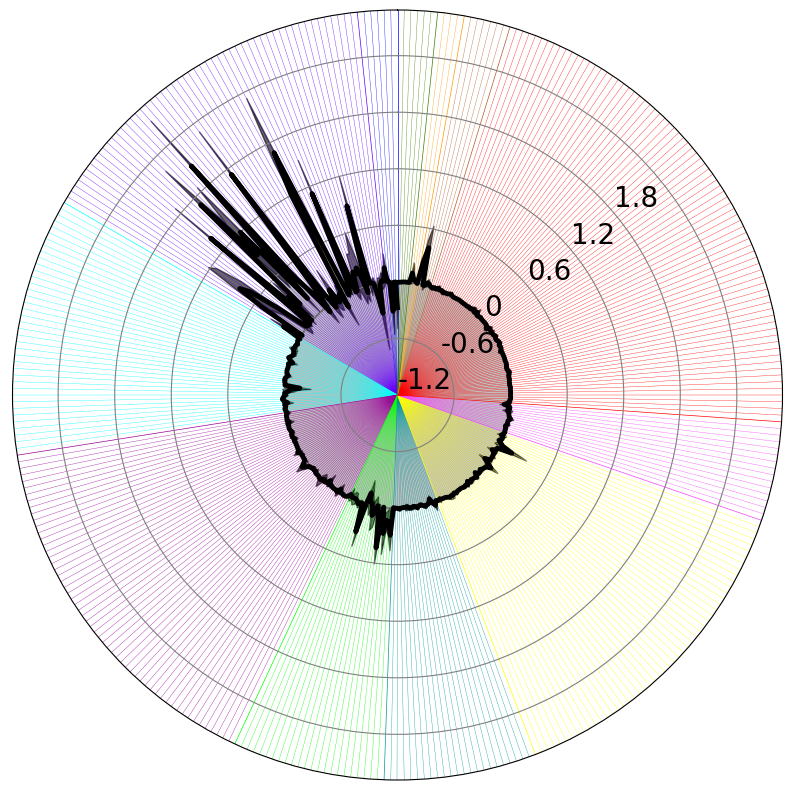

In [105]:
# VISUALIZE: FLOWS 
netNameStrs = ['VIS1', 'VIS2', 'SMN', 'CON', 
               'DAN', 'LAN', 'FPN', 'AUD', 
               'DMN', 'PMM', 'VMM', 'OAN']

flowVecPOI = flowArrAll[parcelOfInterestR,:,:,:]
flowArrSubjsMean = np.nanmean(np.nanmean(np.nanmean(flowVecPOI,axis=0)[:,condsHere,:],
                                         axis=1),axis=1)[net_order]
flowArrAllSubjs = np.nanmean(np.nanmean(flowVecPOI,axis=0)
                             [:,condsHere,:],axis=1)[net_order,:]

lowCIs = np.zeros((num_parcels))
highCIs = np.zeros((num_parcels))
for parcelNum in range(num_parcels):
    lowVal,highVal=sms.DescrStatsW(flowArrAllSubjs[parcelNum,:]).tconfint_mean()
    lowCIs[parcelNum]=lowVal
    highCIs[parcelNum]=highVal
    
figW = 10
figH = 10
fig, axH = plt.subplots(1,figsize=(figW,figH))

plt.style.use('default')
error_alpha = 0.25
radians = np.linspace(0, 2 * np.pi, num=num_parcels, endpoint=False)
ax = plt.axes(polar=True)
ax.set_theta_zero_location('N')
r = np.arange(0,2*np.pi,0.01)
y = np.zeros((len(r)))
ax.plot(r, y,'k',linewidth=1)
ax.set_xticks(radians)
ax.set_xticklabels('')

circle = plt.Circle((0, 0), 1.2, transform=ax.transData._b, 
                    fill=False, edgecolor='lightgrey',
                    linewidth=0.4, zorder=2)
plt.gca().add_artist(circle)

gridlinesHere = ax.xaxis.get_gridlines()
for netNum in range(num_nets):
    colorHere = color_list[netNum]
    startNode = int(boundaries_CA[netNum,0])
    endNode = int(boundaries_CA[netNum,1]+1)
    for parcelNum in range(startNode,endNode):
        gridlinesHere[parcelNum].set_color(colorHere)
        gridlinesHere[parcelNum].set_linewidth(0.25)
    gridlinesHere[startNode].set_linewidth(0.5)

yTickLocs = [-1.2,-0.6,0,0.6,1.2,1.8,2.4]
yTickStr = ['-1.2','-0.6','0','0.6','1.2','1.8','']

ax.plot(radians,flowArrSubjsMean,color='black',
        alpha=1,linewidth=3.5,zorder=3)
ax.fill_between(radians, lowCIs, highCIs, 
                alpha=0.6, color='black')
ax.fill(radians,flowArrSubjsMean,'black',alpha=0.25)

ax.set_yticks(yTickLocs)
ax.set_yticklabels(yTickStr, 
                   color='black', size=20)
ax.set_rlabel_position(-50)
ax.yaxis.grid(True,color='grey')
for tick in ax.get_yticklabels(): 
    tick.set_verticalalignment('bottom')
    
axH.spines['top'].set_visible(False)
axH.spines['bottom'].set_visible(False)
axH.spines['left'].set_visible(False)
axH.spines['right'].set_visible(False)
axH.set_xticks([])
axH.set_yticks([])

plt.show()

# Save
figName = figures_dir + 'network_level_activity_flows_into_EBA_FBA_body_conditions.png'
fig.savefig(figName,bbox_inches='tight',format='png',dpi=600)


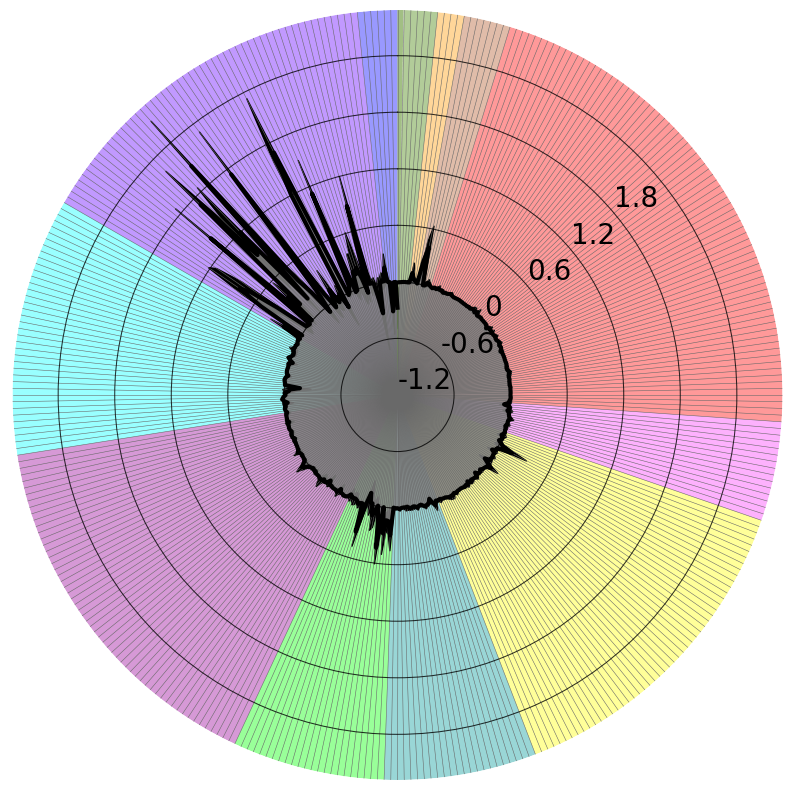

In [106]:
# VISUALIZE FLOWS: alternate 
colorList = [(0, 0, 1),(0.3922, 0, 1),(0, 1, 1),
             (0.6, 0, 0.6),(0, 1, 0),(0, 0.6, 0.6),
             (1, 1, 0),(0.98, 0.24, 0.98),(1, 0, 0),
             (0.7, 0.35, 0.16),(1, 0.6, 0),(0.25, 0.5, 0)]

#############################################################
# VARIABLES THAT CAN BE CHANGED
yTickLocs = [-1.2,-0.6,0,0.6,1.2,1.8,2.4]
yTickStr = ['-1.2','-0.6','0','0.6','1.2','1.8','']
rLabelPos = -50
condsHere = [16,20]
parcelOfInterestR = [181, 315, 317, 335, 336]

flowVecPOI = flowArrAll[parcelOfInterestR,:,:,:]
flowArrSubjsMean = np.nanmean(np.nanmean(np.nanmean(flowVecPOI,axis=0)[:,condsHere,:],axis=1),axis=1)[net_order]
flowArrAllSubjs = np.nanmean(np.nanmean(flowVecPOI,axis=0)[:,condsHere,:],axis=1)[net_order,:]
num_xVars = num_parcels
xVarHereCI = flowArrAllSubjs.copy()
xVarHere = flowArrSubjsMean.copy()

#############################################################
# GET CONFIDENCE INTERVALS
lowCIs = np.zeros((num_xVars))
highCIs = np.zeros((num_xVars))
for xNum in range(num_xVars):
    lowVal,highVal=sms.DescrStatsW(xVarHereCI[xNum,:]).tconfint_mean()
    lowCIs[xNum]=lowVal; highCIs[xNum]=highVal;
    
#############################################################
# FIGURE
figW = 10
figH = 10
fig, axH = plt.subplots(1,figsize=(figW,figH))
plt.style.use('default')

error_alpha = 0.25
ax = plt.axes(polar=True)
radians = np.linspace(0,2*np.pi,num=num_xVars,endpoint=False)
ax.set_theta_zero_location('N')
r = np.arange(0,2*np.pi,0.01)
y = np.zeros((len(r)))
ax.plot(r, y,'k',linewidth=0.5)

xIxs = np.arange(0,num_xVars,1) # Change 3rd # for more/less polar ticks (factors of 360)
ax.set_xticks(radians[xIxs])
ax.set_xticklabels('')
ax.plot(radians,xVarHere,linewidth=3,color='black')
ax.fill_between(radians, lowCIs, highCIs, alpha=1, color='black')
ax.fill(radians,xVarHere,'grey',alpha=0.9)

ax.set_yticks(yTickLocs)
ax.set_yticklabels(yTickStr, color='black', size=20)
ax.set_rlabel_position(rLabelPos)

for tick in ax.get_yticklabels(): 
    tick.set_verticalalignment('bottom')
    tick.set_horizontalalignment('left')

# Turn off the outer grid/axes
axH.spines['top'].set_visible(False)
axH.spines['bottom'].set_visible(False)
axH.spines['left'].set_visible(False)
axH.spines['right'].set_visible(False)
axH.set_xticks([])
axH.set_yticks([])
yMinHere = ax.get_ylim()[0]
yMaxHere = ax.get_ylim()[1]

gridlinesHere=ax.xaxis.get_gridlines()
for netNum in range(num_nets):
    startNode = int(boundaries_CA[netNum,0])
    endNode = int(boundaries_CA[netNum,1]+2)
    ax.fill_between(radians[startNode:endNode],yMinHere,
                    yMaxHere,alpha=0.4,color=color_list[netNum],
                    edgecolor=None,zorder=0)

    # Make the gridlines (x lines) thinner so you can see colors properly
    for nodeHere in range(startNode,endNode-1):
        gridlinesHere[nodeHere].set_linewidth(0.4)
        gridlinesHere[nodeHere].set_color('dimgrey')

    # A trick to fill in the last wedge (for some reason 
    # there's always a disconnect at the origin)
    # NOTE: if you make the gridlines thinner/thicker above, 
    # you'll need to change the width (change denominator)
    ax.bar(2*np.pi,5,width=-np.pi/200,bottom=yMinHere,
           color=color_list[11],edgecolor=None,alpha=0.05,align='edge')

ax.yaxis.grid(True,color='black',linewidth=0.75,alpha=0.8)
plt.ylim(yMinHere,yMaxHere)
plt.box(False)
plt.show()

# Save
figName = figures_dir + 'network_level_activity_flows_into_EBA_FBA_body_conditions_alternative_visualization.png'
fig.savefig(figName,bbox_inches='tight',format='png',dpi=600)

In [108]:
# Max-T nonparametric permutation testing: comparing each 
# network's flow contributions (to EBA/FBA processes) to every other network 
startTime = time.time()

printResults = True

allStrs = ['VIS1', 'VIS2', 'SMN', 'CON', 'DAN', 'LAN', 'FPN', 'AUD', 'DMN', 'PMM', 'VMM', 'OAN']

nullMean = 0
alphaVal = 0.05
tailToUse = 1
numPermsToRun = 10000

initIx = 0
diffArr = np.zeros(((num_nets-1)*(num_nets),num_subjs))
for netNum1 in range(num_nets):
    netOfInterest = netNum1
    netIxList = np.arange(num_nets)
    netIxList = np.delete(netIxList,netOfInterest)
    netOfInterestVals = flowVecNetsSubjsR[netOfInterest,:]
    tempArr = np.zeros((num_nets-1,num_subjs))
    startIx = initIx
    endIx = startIx + num_nets-1
    for netNum2 in range(num_nets-1): 
        thisNetIx = netIxList[netNum2]
        thisNetVals = flowVecNetsSubjsR[thisNetIx,:]
        thisDiff = netOfInterestVals - thisNetVals
        tempArr[netNum2,:] = thisDiff
    diffArr[startIx:endIx,:] = tempArr
    initIx = initIx + num_nets-1

realT,maxTthresh,maxTdistSorted=nppt.maxT(diffArr,nullMean=nullMean,alphaVal=alphaVal,
                                          tailToUse=tailToUse,numPermsToRun=numPermsToRun)

if printResults:
    print('max-T threshold = ' + str(round(maxTthresh,2)))
    print('Data being compared = act-flow products (i.e., '
          +'flow maps before summing) for right ' + 
          parcelStrLong + ', ' + condStrHere + 
          ' conditions, LARGE correction model (ie all nets)...')

    initIx = 0; 

    for netNum1 in range(num_nets): 
        print('\nResults of ' + tailStr + 
              ' max-T-test (nonparametric null distribution, based on ' 
              + str(numPermsToRun) + ' permutations) comparing ' + 
              allStrs[netNum1] + ' vs each other net...'); print(' ')
        netOfInterest = netNum1
        netIxList = np.arange(num_nets)
        netIxList = np.delete(netIxList,netOfInterest)
        startIx = initIx
        endIx = startIx + num_nets-1
        realThere = realT[startIx:endIx]

        for netNum2 in range(num_nets-1):
            thisNetIx = netIxList[netNum2]
            if realThere[netNum2]>maxTthresh:
                sigStr = 'significant'
            else:
                sigStr = 'not significant'
            print(allStrs[netOfInterest] + ' vs. ' + 
                  allStrs[thisNetIx] + ', real-t(' + 
                  str(nSubjsHere-1) + ') = ' + 
                  str(round(realThere[netNum2],2)) + 
                  ' --> ' + sigStr)

        initIx = initIx + num_nets-1
else:      
    print('max-T threshold = ' + str(round(maxTthresh,2)))
    print('Data being compared = act-flow products (i.e., flow '+
          'maps before summing) for right ' + parcelStrLong + ', ' 
          + condStrHere + 
          ' conditions, LARGE correction model (ie all nets)...')

endTime = time.time()
timeDiff = endTime - startTime
print('Cell computation time: ' + str(round(timeDiff/60,2)) + ' minutes.')


max-T threshold = 3.82
Data being compared = act-flow products (i.e., flow maps before summing) for right EBA & FBA, bodies conditions, LARGE correction model (ie all nets)...

Results of upper tailed max-T-test (nonparametric null distribution, based on 10000 permutations) comparing VIS1 vs each other net...
 
VIS1 vs. VIS2, real-t(19) = -10.58 --> not significant
VIS1 vs. SMN, real-t(19) = -3.26 --> not significant
VIS1 vs. CON, real-t(19) = -3.46 --> not significant
VIS1 vs. DAN, real-t(19) = -5.24 --> not significant
VIS1 vs. LAN, real-t(19) = -3.56 --> not significant
VIS1 vs. FPN, real-t(19) = -3.56 --> not significant
VIS1 vs. AUD, real-t(19) = -3.33 --> not significant
VIS1 vs. DMN, real-t(19) = -3.54 --> not significant
VIS1 vs. PMM, real-t(19) = -4.96 --> not significant
VIS1 vs. VMM, real-t(19) = -3.84 --> not significant
VIS1 vs. OAN, real-t(19) = -3.53 --> not significant

Results of upper tailed max-T-test (nonparametric null distribution, based on 10000 permutations) com

In [119]:
# Dominance analysis: network contributions to response profile 
# i.e., the cross 24 HCP condition responses of EBA/FBA 
# Partial explained variance (R-sq.); see for manuscript details, or
# see here: https://github.com/dominance-analysis/dominance-analysis

# NOTE: this will take ~6 mins per subject (~2 hours for n=20)
# So the below code only runs for 5 subjects (very low powered; demo purposes only)
# Consider using HPC for large datasets.

startTime = time.time()

# NOTE: may want to use dominance_analysis_V2 instead; see function descriptions
import dominance_analysis as dom

saveTagComplex = 'right EBA/FBA'

actPredArray_NetMeans_AllR = np.zeros((num_nets,len(parcelOfInterestR),num_conditions,num_subjs))
for subjNum in range(num_subjs):
    for netNum in range(num_nets):
        startNode = int(boundaries_CA[netNum,0])
        endNode = int(boundaries_CA[netNum,1]+1)
        actPredArray_NetMeans_AllR[netNum,:,:,subjNum] = np.nanmean(flowArrAll[parcelOfInterestR,:,:,subjNum]
                                                                    [:,net_order,:][:,startNode:endNode,:],axis=1)
        
with open(data_dir+'parcelIx.txt', 'w') as fileHandle:
    for listItem in parcelOfInterestR:
        fileHandle.write('%s\n' % listItem)

parcelOfInterestHere = data_dir+'parcelIx.txt'
print('Running dominance analysis of network '+
      'influences to activity flow mapping '+
      '(cross-condition/response profile) for ' 
      + saveTagComplex + '...')

########################################################
subjsToRun = 5
rsqFull_All = np.zeros((subjsToRun))
netVarExplDom_All = np.zeros((num_nets,subjsToRun))
netVarImportance_All = np.zeros((num_nets,subjsToRun))

# Run for 5 subjects only (~30 minutes)
for subjNum in range(0,subjsToRun):
    if subjNum % 1 == 0: 
        print(f"Running dominance analysis on subject {subjNum}...")
    preds_nets = actPredArray_NetRestricted_AllR[:,:,:,subjNum]
    preds_netmeans = actPredArray_NetMeans_AllR[:,:,:,subjNum]
    acts = actual_activations[:,:,subjNum]
    rsq,nv,nvi = dom.dominance_analysis_slurm(preds_nets,preds_netmeans,acts,parcelOfInterestHere)
    rsqFull_All[subjNum] = rsq
    netVarExplDom_All[:,subjNum] = nv
    netVarImportance_All[:,subjNum] = nvi
    
endTime = time.time()
timeDiff = endTime - startTime
print('Cell computation time: ' + str(round(timeDiff/60,2)) + ' minutes.')


Running dominance analysis of network influences to activity flow mapping (cross-condition/response profile) for right EBA/FBA...
Running dominance analysis on subject 0...
Running dominance analysis on subject 1...
Running dominance analysis on subject 2...
Running dominance analysis on subject 3...
Running dominance analysis on subject 4...
Cell computation time: 27.41 minutes.


In [120]:
# Print results from dominance analysis performed above 

hemiStr = 'right hemisphere'

print('\n' + hemiStr + ': ' + 'Percentages of relative '+
      'importance per network (cross-subj avg), for '+
      'cross-condition (response profile) AF prediction model of ' 
      + parcelStrLong + '...')

for netNum in range(num_nets):
    print(allStrs[netNum] + ': ' + str(np.round(np.nanmean(netVarImportance_All,axis=1)[netNum],2)) + '%')

if np.nansum(np.nanmean(netVarImportance_All,axis=1))<=99.9:
    print('\nPercents do not add to ~100%, please check.')

print('\n' + hemiStr + ': ' + 'Estimated partial r-sq. '+
      '(dominance analysis method) per network (cross-subj '+
      'avg), for cross-condition (response profile) AF '+
      'prediction model of ' + parcelStrLong + '...')

for netNum in range(num_nets):
    print(allStrs[netNum] + ': ' + str(np.round(np.nanmean(netVarExplDom_All,axis=1)[netNum],4)))

print('\n' + hemiStr + ': ' + 'Full model r-sq. (multiple '+
      'regression where AF-predicted cross-condition vals '+
      'for each net = 12 IVs; actual cross-condition vals = '+
      'DV) = ' + str(np.round(np.nanmean(rsqFull_All),4)))

if np.round(np.nansum(np.nanmean(netVarExplDom_All,axis=1)),5)!=np.round(np.nanmean(rsqFull_All),5):
    print('\nPartial variances do not add up to full-model variance, please check.')



right hemisphere: Percentages of relative importance per network (cross-subj avg), for cross-condition (response profile) AF prediction model of EBA & FBA...
VIS1: 3.53%
VIS2: 63.71%
SMN: 1.13%
CON: 5.2%
DAN: 10.0%
LAN: 4.25%
FPN: 1.23%
AUD: 1.53%
DMN: 1.19%
PMM: 6.12%
VMM: 1.77%
OAN: 0.35%

right hemisphere: Estimated partial r-sq. (dominance analysis method) per network (cross-subj avg), for cross-condition (response profile) AF prediction model of EBA & FBA...
VIS1: 0.0301
VIS2: 0.5313
SMN: 0.0093
CON: 0.0434
DAN: 0.084
LAN: 0.035
FPN: 0.0101
AUD: 0.0128
DMN: 0.01
PMM: 0.0514
VMM: 0.0139
OAN: 0.003

right hemisphere: Full model r-sq. (multiple regression where AF-predicted cross-condition vals for each net = 12 IVs; actual cross-condition vals = DV) = 0.8343


In [121]:
# Is total R2 (from dominance analysis) greater than 0.5?

popMean = 0.5

tstat, pVal = stats.ttest_1samp(rsqFull_All,popMean)

print('\nRIGHT HEMISPHERE ' + parcelStrLong + ': total model R-sq., cross-subj mean = ' + 
      str(np.round(np.nanmean(rsqFull_All),3)) + ' vs 0.5 (1 sample t-test): t(' + 
      str(subjsToRun-1) + ') = ' + str(np.round(tstat,2)) + ', p = ' + str(pVal))



RIGHT HEMISPHERE EBA & FBA: total model R-sq., cross-subj mean = 0.834 vs 0.5 (1 sample t-test): t(4) = 18.79, p = 4.728569790505391e-05


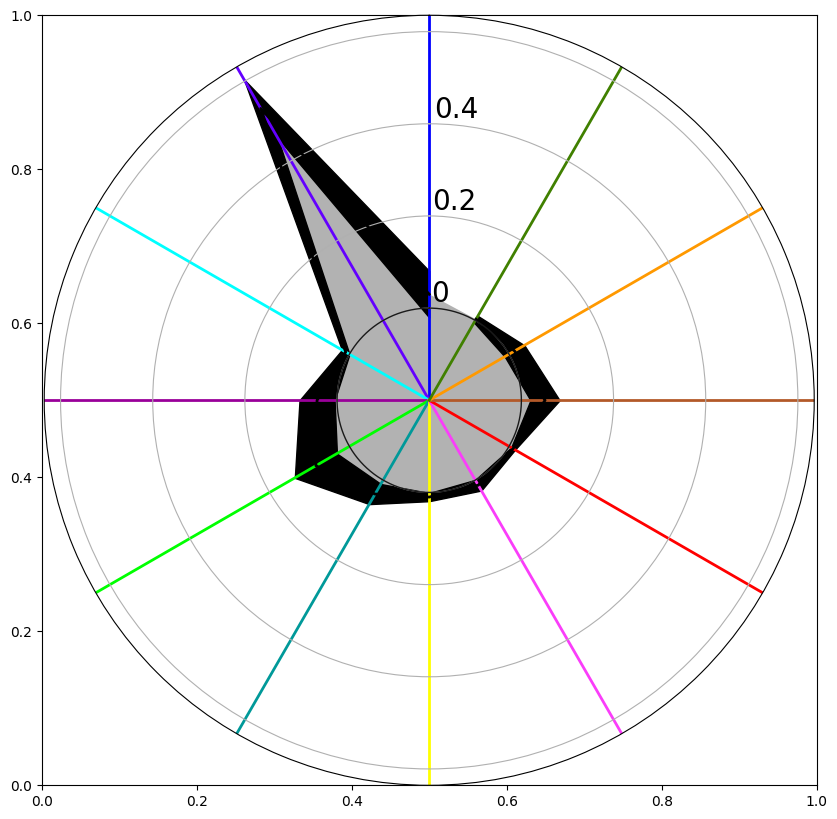

In [123]:
# Visualize dominance analysis results 

explVar_SubjMeans = np.nanmean(netVarExplDom_All,axis=1)
lowCIs = np.zeros((num_nets))
highCIs = np.zeros((num_nets))
for netNum in range(num_nets):
    lowVal, highVal = sms.DescrStatsW(netVarExplDom_All[netNum,:]).tconfint_mean()
    lowCIs[netNum] = lowVal
    highCIs[netNum] = highVal
    
figW = 10
figH = 10
fig, ax = plt.subplots(1,figsize=(figW,figH))

plt.style.use('default')
error_alpha = 0.25
radians = np.linspace(0, 2 * np.pi, num=num_nets, endpoint=False)
ax = plt.axes(polar=True)
ax.set_theta_zero_location('N')
r = np.arange(0,2*np.pi,0.01)
y = np.zeros((len(r)))
ax.plot(r, y,'k',linewidth=1,zorder=10)
ax.set_xticks(radians)
ax.set_xticklabels('') 
#ax.set_xticklabels(allStrs, size=20)

colorList = [(0, 0, 1),(0.3922, 0, 1),(0, 1, 1),
             (0.6, 0, 0.6),(0, 1, 0),(0, 0.6, 0.6),
             (1, 1, 0),(0.98, 0.24, 0.98),(1, 0, 0),
             (0.7, 0.35, 0.16),(1, 0.6, 0),
             (0.25, 0.5, 0)]
gridlinesHere = ax.xaxis.get_gridlines()
for netNum in range(num_nets):
    colorHere = color_list[netNum]
    gridlinesHere[netNum].set_color(colorHere)
    #gridlinesHere[netNum].set_color('lightgrey')
    gridlinesHere[netNum].set_linewidth(2)

yTickLocs = [-0.2,0,0.2,0.4,0.6]
yTickStr = ['','0','0.2','0.4',''] 

ax.plot(radians, explVar_SubjMeans,linewidth=2, color='black')
ax.fill_between(radians, lowCIs, highCIs, alpha=1, color='black')
ax.fill(radians,explVar_SubjMeans,'black',alpha=0.3) 
#ax.fill(radians,explVar_SubjMeans,'lightgrey',alpha=1,zorder=2)

for label, angle in zip(ax.get_xticklabels(), radians): 
    if angle in (0, np.pi):
        label.set_horizontalalignment('center')
    elif 0 < angle < np.pi:
        label.set_horizontalalignment('right')
    else:
        label.set_horizontalalignment('left')


ax.set_yticks(yTickLocs)
ax.set_yticklabels(yTickStr, color='black', size=20)
ax.set_rlabel_position(-1)
for tick in ax.get_yticklabels(): 
        tick.set_verticalalignment('bottom')

plt.show()

# Save
figName = figures_dir + 'network_level_unmixed_contributions_into_EBA_FBA_across_conditions.png'
fig.savefig(figName,bbox_inches='tight',format='png',dpi=600)

# Null connectivity model

In [ ]:
# NOTE: analyses of the bodies complex (right hemisphere EBA/FBA) are 
# demonstrated below only (to conserve space).
# NOTE: reduced statistical power here (n=20) vs manuscript results (n=176).

In [109]:
# Null connectivity fingerprint models: substitution approach 
# See manuscript for details 

startTime = time.time()

###############################################################
# BODIES complex replaced with FACES (_NULL_BF_)
print('\nComputing null model for BODY complex: replacing '+
      'BODY complex rsFC estimates with FACE complex '+
      'rsFC estimates...')
restFC_NULL_BF = restFC.copy()
restFC_NULL_BF[parcelOfInterestR_body,:,:] = np.nanmean(restFC[parcelOfInterestR_body,:,:],axis=0).copy()
restFC_NULL_BF[parcelOfInterestL_body,:,:] = np.nanmean(restFC[parcelOfInterestL_body,:,:],axis=0).copy()

# Set null complex's self connections (which were 0) 
# to the connections with the complex of interest (ie reverse them)
for subjNum in range(num_subjs):
    rightRevHere = restFC[parcelOfInterestR_face,:,subjNum][:,parcelOfInterestR_body].T.copy()
    leftRevHere = restFC[parcelOfInterestL_face,:,subjNum][:,parcelOfInterestL_body].T.copy()
    for fROI in range(len(parcelOfInterestR_body)):
        thisROIix_R = parcelOfInterestR_body[fROI]
        thisROIix_L = parcelOfInterestL_body[fROI]
        restFC_NULL_BF[thisROIix_R,parcelOfInterestR_face,subjNum] = rightRevHere[fROI,:]
        restFC_NULL_BF[thisROIix_L,parcelOfInterestL_face,subjNum] = leftRevHere[fROI,:]
        
# Set self connections to 0
for subjNum in range(num_subjs):
    rsFCHere = restFC_NULL_BF[parcelOfInterestR_body,:,subjNum]
    rsFCHere[:,parcelOfInterestR_body] = 0
    restFC_NULL_BF[parcelOfInterestR_body,:,subjNum] = rsFCHere
    rsFCHere = restFC_NULL_BF[parcelOfInterestL_body,:,subjNum]
    rsFCHere[:,parcelOfInterestL_body] = 0
    restFC_NULL_BF[parcelOfInterestL_body,:,subjNum] = rsFCHere
    
# Compute null model activity flow 
print('******** Activity flow mapping results, combinedFC + '+
      'multreg-based rest --> NULL MODEL: rsFC BODY COMPLEX '+
      'rsFC REPLACED WITH FACE COMPLEX rsFC, 24 task conditions ********')
actflowOutput_NULL_BF = actflow.actflowcomp.actflowtest(actual_activations, restFC_NULL_BF)

###############################################################
# BODIES complex replaced with PLACES (_NULL_BP_)
print('\nComputing null model for BODY complex: replacing'+
      ' BODY complex rsFC estimates with PLACE complex rsFC estimates...')
restFC_NULL_BP = restFC.copy()
restFC_NULL_BP[parcelOfInterestR_body,:,:] = np.nanmean(restFC[parcelOfInterestR_place,:,:],axis=0).copy()
restFC_NULL_BP[parcelOfInterestL_body,:,:] = np.nanmean(restFC[parcelOfInterestL_place,:,:],axis=0).copy()

for subjNum in range(num_subjs):
    rightRevHere = restFC[parcelOfInterestR_place,:,subjNum][:,parcelOfInterestR_body].T.copy()
    leftRevHere = restFC[parcelOfInterestL_place,:,subjNum][:,parcelOfInterestL_body].T.copy()
    for fROI in range(len(parcelOfInterestR_body)):
        thisROIix_R = parcelOfInterestR_body[fROI]
        thisROIix_L = parcelOfInterestL_body[fROI]
        restFC_NULL_BP[thisROIix_R,parcelOfInterestR_place,subjNum] = rightRevHere[fROI,:]
        restFC_NULL_BP[thisROIix_L,parcelOfInterestL_place,subjNum] = leftRevHere[fROI,:]
        
for subjNum in range(num_subjs):
    rsFCHere = restFC_NULL_BP[parcelOfInterestR_body,:,subjNum]
    rsFCHere[:,parcelOfInterestR_body] = 0
    restFC_NULL_BP[parcelOfInterestR_body,:,subjNum] = rsFCHere
    rsFCHere = restFC_NULL_BP[parcelOfInterestL_body,:,subjNum]
    rsFCHere[:,parcelOfInterestL_body] = 0
    restFC_NULL_BP[parcelOfInterestL_body,:,subjNum] = rsFCHere
    
# Compute null model activity flow 
print('******** Activity flow mapping results, combinedFC + '+
      'multreg-based rest --> NULL MODEL: rsFC BODY COMPLEX '+
      'rsFC REPLACES WITH PLACE COMPLEX rsFC, 24 task conditions ********')
actflowOutput_NULL_BP = actflow.actflowcomp.actflowtest(actual_activations, restFC_NULL_BP) 

###############################################################
# BODIES complex replaced with TOOLS (_NULL_BT_)
print('\nComputing null model for BODY complex: replacing '+
      'BODY complex rsFC estimates with TOOL complex rsFC estimates...')
restFC_NULL_BT = restFC.copy()
restFC_NULL_BT[parcelOfInterestR_body,:,:] = np.nanmean(restFC[parcelOfInterestR_tool],axis=0)
restFC_NULL_BT[parcelOfInterestL_body,:,:] = np.nanmean(restFC[parcelOfInterestL_tool],axis=0)

for subjNum in range(num_subjs):
    rightRevHere = restFC[parcelOfInterestR_tool,:,subjNum][:,parcelOfInterestR_body].T.copy()
    leftRevHere = restFC[parcelOfInterestL_tool,:,subjNum][:,parcelOfInterestL_body].T.copy()
    for fROI in range(len(parcelOfInterestR_body)):
        thisROIix_R = parcelOfInterestR_body[fROI]
        thisROIix_L = parcelOfInterestL_body[fROI]
        restFC_NULL_BT[thisROIix_R,parcelOfInterestR_tool,subjNum] = rightRevHere[fROI,:]
        restFC_NULL_BT[thisROIix_L,parcelOfInterestL_tool,subjNum] = leftRevHere[fROI,:]
        
for subjNum in range(num_subjs):
    rsFCHere = restFC_NULL_BT[parcelOfInterestR_body,:,subjNum]
    rsFCHere[:,parcelOfInterestR_body] = 0
    restFC_NULL_BT[parcelOfInterestR_body,:,subjNum] = rsFCHere
    rsFCHere = restFC_NULL_BT[parcelOfInterestL_body,:,subjNum]
    rsFCHere[:,parcelOfInterestL_body] = 0
    restFC_NULL_BT[parcelOfInterestL_body,:,subjNum] = rsFCHere

    # Compute null model activity flow 
print('******** Activity flow mapping results, combinedFC + '+
      'multreg-based rest --> NULL MODEL: rsFC BODY COMPLEX '+
      'rsFC REPLACED WITH TOOL COMPLEX rsFC, 24 task conditions ********') 
actflowOutput_NULL_BT = actflow.actflowcomp.actflowtest(actual_activations, restFC_NULL_BT)  

endTime = time.time()
timeHere = (endTime-startTime)/60
print('\nCell computation time: ' + str(round(timeHere,2)) + ' minutes')


Computing null model for BODY complex: replacing BODY complex rsFC estimates with FACE complex rsFC estimates...
******** Activity flow mapping results, combinedFC + multreg-based rest --> NULL MODEL: rsFC BODY COMPLEX rsFC REPLACED WITH FACE COMPLEX rsFC, 24 task conditions ********
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 20 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.86, t-value vs. 0: 54.39, p-value vs. 0: 2.5436718572163e-22
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.73
 
Mean MAE (mean absolute error) = 6.19
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not

In [111]:
# Compute true model BODY selectivity (also computed a few sections above)
# NOTE: that computation involves removing outliers 
# (does not impact significance in any case)
# did not remove them here so subject numbers are the same with null model comparisons

actData = actual_activations.copy()
predData = actflowOutput_bycond['actPredVector_bytask_bysubj'].copy()

##########################################################################
# Compute category selectivity for BODIES (TRUE)
print('\nTRUE category selectivity results, BODY SELECTIVITY...\n');

category_indices = [16,20]
noncategory_indices = [17,18,19,21,22,23]
catStrHere = 'bodies'
wmIxsCat = [0, 4]
wmIxsNonCat = [1, 2, 3, 5, 6, 7]
parcelStrLong = 'EBA & FBA'
parcelOfInterestR = [181, 315, 317, 335, 336]
parcelStrR = 'rmodBC'
predDataHereR = predData[parcelOfInterestR,:,:].copy()
actDataHereR = actData[parcelOfInterestR,:,:].copy()
taskOfInterest = 0
taskListShort = np.array([0,1,2,3])
nonTaskIxsShort = np.where(taskListShort!=taskOfInterest)[0]

##########################################################################
# Compute true model category selectivity
minVal = 0
maxVal = 1
numDevs = 5
useBothSets = True
csAct,csPred,csActArr,csPredArr = cs.category_selectivity(actDataHereR,
                                                          predDataHereR,
                                                          category_indices,
                                                          noncategory_indices,
                                                          norm_method='min-max',
                                                          min_val=minVal,
                                                          max_val=maxVal,
                                                          hcp_nbacks=True)
predMetricSubjs_ModR_True = csPred.copy()
actMetricSubjs_ModR_True = csAct.copy()
distPercR = (np.nanmean(predMetricSubjs_ModR_True)/np.nanmean(actMetricSubjs_ModR_True)) * 100
dataActualR = {catStrHere:actMetricSubjs_ModR_True}
dfActualR = pd.DataFrame(dataActualR)
dataPredR = {catStrHere:predMetricSubjs_ModR_True}
dfPredR = pd.DataFrame(dataPredR)

##########################################################################
# RESULTS
percPredMeanR = distPercR

hypoMean = 1
tValActR,pValActR = stats.ttest_1samp(actMetricSubjs_ModR_True,hypoMean)
tValPredR,pValPredR = stats.ttest_1samp(predMetricSubjs_ModR_True,hypoMean)

print('Actual category selectivity to images of ' + 
      catStrHere + ' in the right hemisphere ' + 
      parcelStrLong + ' (cross-subject mean) = ' + 
      str(np.round(np.nanmean(actMetricSubjs_ModR_True),2)))
print('Compared to null mean of ' + str(hypoMean) + ': t(' + 
      str(num_subjs-2) +') = ' + str(round(tValActR,2)) + 
      ', p = ' + '{:0.2e}'.format(pValActR))

print('\nPredicted category selectivity to images of ' + 
      catStrHere + ' in the right hemisphere ' + 
      parcelStrLong + ' (cross-subject mean) = ' + 
      str(np.round(np.nanmean(predMetricSubjs_ModR_True),2)))
print('Compared to null mean of ' + str(hypoMean) + 
      ': t(' + str(num_subjs-1) +') = ' + str(round(tValPredR,2)) 
      + ', p = ' + '{:0.2e}'.format(pValPredR))


TRUE category selectivity results, BODY SELECTIVITY...

Actual category selectivity to images of bodies in the right hemisphere EBA & FBA (cross-subject mean) = 1.71
Compared to null mean of 1: t(18) = 6.48, p = 3.32e-06

Predicted category selectivity to images of bodies in the right hemisphere EBA & FBA (cross-subject mean) = 1.64
Compared to null mean of 1: t(19) = 2.76, p = 1.25e-02


In [112]:
# Null model activity flow: replacing one complex's connectivity 
# fingerprint with another: BODIES replaced with FACES 

actData = actual_activations.copy()
predData = actflowOutput_NULL_BF['actPredVector_bytask_bysubj'].copy()

print('\nNULL category selectivity results with BODY COMPLEX rsFC replaced by FACE COMPLEX rsFC...\n')

category_indices = [16,20]
noncategory_indices = [17,18,19,21,22,23]
catStrHere = 'bodies'
wmIxsCat = [0, 4]
wmIxsNonCat = [1, 2, 3, 5, 6, 7]
parcelStrLong = 'EBA & FBA'
parcelOfInterestR = [181, 315, 317, 335, 336]
parcelStrR = 'rmodBC'
predDataHereR = predData[parcelOfInterestR,:,:].copy()
actDataHereR = actData[parcelOfInterestR,:,:].copy()
taskOfInterest = 0
taskListShort = np.array([0,1,2,3])
nonTaskIxsShort = np.where(taskListShort!=taskOfInterest)[0]

minVal = 0
maxVal = 1
numDevs = 5
removeOutliers = False
useBothSets = True

##########################################################################
# Compute null model category selectivity
csAct,csPred,csActArr,csPredArr = cs.category_selectivity(actDataHereR,
                                                          predDataHereR,
                                                          category_indices,
                                                          noncategory_indices,
                                                          norm_method='min-max',
                                                          min_val=minVal,
                                                          max_val=maxVal,
                                                          hcp_nbacks=True)
predMetricSubjs_ModR = csPred.copy()
actMetricSubjs_ModR = csAct.copy()
distPercR = (np.nanmean(predMetricSubjs_ModR)/np.nanmean(actMetricSubjs_ModR)) * 100
dataActualR = {catStrHere:actMetricSubjs_ModR}
dfActualR = pd.DataFrame(dataActualR)
dataPredR = {catStrHere:predMetricSubjs_ModR}
dfPredR = pd.DataFrame(dataPredR)

##########################################################################
# RESULTS
percPredMeanR = distPercR

hypoMean = 1
tValActR,pValActR = stats.ttest_1samp(actMetricSubjs_ModR,hypoMean)
tValPredR,pValPredR = stats.ttest_1samp(predMetricSubjs_ModR,hypoMean)

print('Actual category selectivity to images of ' + 
      catStrHere + ' in the right hemisphere ' + 
      parcelStrLong + ' (cross-subject mean) = ' + 
      str(np.round(np.nanmean(actMetricSubjs_ModR),2)))
print('Compared to null mean of ' + str(hypoMean) + ': t(' + 
      str(num_subjs-2) +') = ' + str(round(tValActR,2)) + 
      ', p = ' + '{:0.2e}'.format(pValActR))

print('\nPredicted category selectivity to images of ' + 
      catStrHere + ' in the right hemisphere ' + 
      parcelStrLong + ' (cross-subject mean) = ' + 
      str(np.round(np.nanmean(predMetricSubjs_ModR),2)))
print('Compared to null mean of ' + str(hypoMean) + 
      ': t(' + str(num_subjs-1) +') = ' + str(round(tValPredR,2)) 
      + ', p = ' + '{:0.2e}'.format(pValPredR))

########################################################################
# Test: is true model selectivity > null model selectivity? 

tValNullPredR, pValNullPredR = stats.ttest_rel(predMetricSubjs_ModR_True,predMetricSubjs_ModR)
print('\nComparison of PREDICTED ' + catStrHere + 
      ' selectivity, true vs null model, RIGHT hemisphere: t(' 
      + str(num_subjs-1) + ') = ' + str(np.round(tValNullPredR,2)) 
      + ', p = ' + str(pValNullPredR))



NULL category selectivity results with BODY COMPLEX rsFC replaced by FACE COMPLEX rsFC...

Actual category selectivity to images of bodies in the right hemisphere EBA & FBA (cross-subject mean) = 1.71
Compared to null mean of 1: t(18) = 6.48, p = 3.32e-06

Predicted category selectivity to images of bodies in the right hemisphere EBA & FBA (cross-subject mean) = 1.22
Compared to null mean of 1: t(19) = 5.13, p = 5.99e-05

Comparison of PREDICTED bodies selectivity, true vs null model, RIGHT hemisphere: t(19) = 2.03, p = 0.056600443453811565


In [113]:
# Null model activity flow: replacing one complex's connectivity 
# fingerprint with another: BODIES replaced with PLACES 

actData = actual_activations.copy()
predData = actflowOutput_NULL_BP['actPredVector_bytask_bysubj'].copy()

print('\nNULL category selectivity results with BODY COMPLEX'+
      ' rsFC replaced by PLACE COMPLEX rsFC...\n')

category_indices = [16,20]
noncategory_indices = [17,18,19,21,22,23]
catStrHere = 'bodies'
wmIxsCat = [0, 4]
wmIxsNonCat = [1, 2, 3, 5, 6, 7]
parcelStrLong = 'EBA & FBA'
parcelOfInterestR = [181, 315, 317, 335, 336]
parcelStrR = 'rmodBC'
predDataHereR = predData[parcelOfInterestR,:,:].copy()
actDataHereR = actData[parcelOfInterestR,:,:].copy()
taskOfInterest = 0
taskListShort = np.array([0,1,2,3])
nonTaskIxsShort = np.where(taskListShort!=taskOfInterest)[0]

minVal = 0
maxVal = 1
numDevs = 5
removeOutliers = False
useBothSets = True

##########################################################################
# Compute null model category selectivity
csAct,csPred,csActArr,csPredArr = cs.category_selectivity(actDataHereR,
                                                          predDataHereR,
                                                          category_indices,
                                                          noncategory_indices,
                                                          norm_method='min-max',
                                                          min_val=minVal,
                                                          max_val=maxVal,
                                                          hcp_nbacks=True)
predMetricSubjs_ModR = csPred.copy()
actMetricSubjs_ModR = csAct.copy()
distPercR = (np.nanmean(predMetricSubjs_ModR)/np.nanmean(actMetricSubjs_ModR)) * 100
dataActualR = {catStrHere:actMetricSubjs_ModR}
dfActualR = pd.DataFrame(dataActualR)
dataPredR = {catStrHere:predMetricSubjs_ModR}
dfPredR = pd.DataFrame(dataPredR)

#########################################################################
# RESULTS
percPredMeanR = distPercR

hypoMean = 1
tValActR,pValActR = stats.ttest_1samp(actMetricSubjs_ModR,hypoMean)
tValPredR,pValPredR = stats.ttest_1samp(predMetricSubjs_ModR,hypoMean)

print('Actual category selectivity to images of ' + 
      catStrHere + ' in the right hemisphere ' + 
      parcelStrLong + ' (cross-subject mean) = ' + 
      str(np.round(np.nanmean(actMetricSubjs_ModR),2)))
print('Compared to null mean of ' + str(hypoMean) + ': t(' + 
      str(num_subjs-2) +') = ' + str(round(tValActR,2)) + 
      ', p = ' + '{:0.2e}'.format(pValActR))

print('\nPredicted category selectivity to images of ' + 
      catStrHere + ' in the right hemisphere ' + 
      parcelStrLong + ' (cross-subject mean) = ' + 
      str(np.round(np.nanmean(predMetricSubjs_ModR),2)))
print('Compared to null mean of ' + str(hypoMean) + 
      ': t(' + str(num_subjs-1) +') = ' + str(round(tValPredR,2)) 
      + ', p = ' + '{:0.2e}'.format(pValPredR))
    
##########################################################################
# Test: is true model selectivity > null model selectivity? 
tValNullPredR, pValNullPredR = stats.ttest_rel(predMetricSubjs_ModR_True,predMetricSubjs_ModR)

print('\nComparison of PREDICTED ' + catStrHere + 
      ' selectivity, true vs null model, RIGHT hemisphere: t(' + 
      str(num_subjs-1) + ') = ' + str(np.round(tValNullPredR,2)) + 
      ', p = ' + str(pValNullPredR))



NULL category selectivity results with BODY COMPLEX rsFC replaced by PLACE COMPLEX rsFC...

Actual category selectivity to images of bodies in the right hemisphere EBA & FBA (cross-subject mean) = 1.71
Compared to null mean of 1: t(18) = 6.48, p = 3.32e-06

Predicted category selectivity to images of bodies in the right hemisphere EBA & FBA (cross-subject mean) = 0.92
Compared to null mean of 1: t(19) = -3.16, p = 5.14e-03

Comparison of PREDICTED bodies selectivity, true vs null model, RIGHT hemisphere: t(19) = 3.17, p = 0.005053962281064036


In [114]:
# Null model activity flow: replacing one complex's connectivity 
# fingerprint with another: BODIES replaced with TOOLS 

actData = actual_activations.copy()
predData = actflowOutput_NULL_BT['actPredVector_bytask_bysubj'].copy()

print('\nNULL category selectivity results with BODY COMPLEX'+
      ' rsFC replaced by TOOL COMPLEX rsFC...\n')

category_indices = [16,20]
noncategory_indices = [17,18,19,21,22,23]
catStrHere = 'bodies'
wmIxsCat = [0, 4]
wmIxsNonCat = [1, 2, 3, 5, 6, 7]
parcelStrLong = 'EBA & FBA'
parcelOfInterestR = [181, 315, 317, 335, 336]
parcelStrR = 'rmodBC'
predDataHereR = predData[parcelOfInterestR,:,:].copy()
actDataHereR = actData[parcelOfInterestR,:,:].copy()
taskOfInterest = 0
taskListShort = np.array([0,1,2,3])
nonTaskIxsShort = np.where(taskListShort!=taskOfInterest)[0]

minVal = 0
maxVal = 1
numDevs = 5
removeOutliers = False
useBothSets = True

##########################################################################
# Compute null model category selectivity
csAct,csPred,csActArr,csPredArr = cs.category_selectivity(actDataHereR,
                                                          predDataHereR,
                                                          category_indices,
                                                          noncategory_indices,
                                                          norm_method='min-max',
                                                          min_val=minVal,
                                                          max_val=maxVal,
                                                          hcp_nbacks=True)
predMetricSubjs_ModR = csPred.copy()
actMetricSubjs_ModR = csAct.copy()

distPercR = (np.nanmean(predMetricSubjs_ModR)/np.nanmean(actMetricSubjs_ModR)) * 100
dataActualR = {catStrHere:actMetricSubjs_ModR}
dfActualR = pd.DataFrame(dataActualR)
dataPredR = {catStrHere:predMetricSubjs_ModR}
dfPredR = pd.DataFrame(dataPredR)

############################################################################
# RESULTS
percPredMeanR = distPercR

hypoMean = 1
tValActR,pValActR = stats.ttest_1samp(actMetricSubjs_ModR,hypoMean)
tValPredR,pValPredR = stats.ttest_1samp(predMetricSubjs_ModR,hypoMean)

print('Actual category selectivity to images of ' + 
      catStrHere + ' in the right hemisphere ' + 
      parcelStrLong + ' (cross-subject mean) = ' + 
      str(np.round(np.nanmean(actMetricSubjs_ModR),2)))
print('Compared to null mean of ' + str(hypoMean) + ': t(' + 
      str(num_subjs-2) +') = ' + str(round(tValActR,2)) + 
      ', p = ' + '{:0.2e}'.format(pValActR))

print('\nPredicted category selectivity to images of ' + 
      catStrHere + ' in the right hemisphere ' + 
      parcelStrLong + ' (cross-subject mean) = ' + 
      str(np.round(np.nanmean(predMetricSubjs_ModR),2)))
print('Compared to null mean of ' + str(hypoMean) + 
      ': t(' + str(num_subjs-1) +') = ' + str(round(tValPredR,2)) 
      + ', p = ' + '{:0.2e}'.format(pValPredR))
    
#############################################################################
# Test: is true model selectivity > null model selectivity? 
tValNullPredR, pValNullPredR = stats.ttest_rel(predMetricSubjs_ModR_True,predMetricSubjs_ModR)

print('\nComparison of PREDICTED ' + catStrHere + 
      ' selectivity, true vs null model, RIGHT hemisphere: t(' 
      + str(num_subjs-1) + ') = ' + str(np.round(tValNullPredR,2)) + 
      ', p = ' + str(pValNullPredR))



NULL category selectivity results with BODY COMPLEX rsFC replaced by TOOL COMPLEX rsFC...

Actual category selectivity to images of bodies in the right hemisphere EBA & FBA (cross-subject mean) = 1.71
Compared to null mean of 1: t(18) = 6.48, p = 3.32e-06

Predicted category selectivity to images of bodies in the right hemisphere EBA & FBA (cross-subject mean) = 0.96
Compared to null mean of 1: t(19) = -2.57, p = 1.86e-02

Comparison of PREDICTED bodies selectivity, true vs null model, RIGHT hemisphere: t(19) = 3.03, p = 0.006942968418675721
